# IMPORTS

In [3]:
#!pip install --upgrade numpy

In [2]:
import math
import numpy  as np
import pandas as pd
import random
import sweetviz as sv
import pickle
import warnings
import inflection
import seaborn as sns
import xgboost as xgb
from scipy.stats import shapiro

from scipy                 import stats  as ss
from boruta                import BorutaPy
from matplotlib            import pyplot as plt
from IPython.display       import Image
from IPython.core.display  import HTML

from sklearn.metrics       import mean_absolute_error, mean_squared_error
from sklearn.ensemble      import RandomForestRegressor
from sklearn.linear_model  import LinearRegression, Lasso
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.ensemble        import RandomForestRegressor

warnings.filterwarnings( 'ignore' )

## Helper Functions

In [5]:
def cross_validation( x_training, kfold, model_name, model, verbose=False ):
    mae_list = []
    mape_list = []
    rmse_list = []
    for k in reversed( range( 1, kfold+1 ) ):
        if verbose:
            print( '\nKFold Number: {}'.format( k ) )
        # start and end date for validation 
        validation_start_date = x_training['date'].max() - datetime.timedelta( days=k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta( days=(k-1)*6*7)

        # filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        # training and validation dataset
        # training
        xtraining = training.drop( ['date', 'sales'], axis=1 ) 
        ytraining = training['sales']

        # validation
        xvalidation = validation.drop( ['date', 'sales'], axis=1 )
        yvalidation = validation['sales']

        # model
        m = model.fit( xtraining, ytraining )

        # prediction
        yhat = m.predict( xvalidation )

        # performance
        m_result = ml_error( model_name, np.expm1( yvalidation ), np.expm1( yhat ) )

        # store performance of each kfold iteration
        mae_list.append(  m_result['MAE'] )
        mape_list.append( m_result['MAPE'] )
        rmse_list.append( m_result['RMSE'] )

    return pd.DataFrame( {'Model Name': model_name,
                          'MAE CV': np.round( np.mean( mae_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mae_list ), 2 ).astype( str ),
                          'MAPE CV': np.round( np.mean( mape_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mape_list ), 2 ).astype( str ),
                          'RMSE CV': np.round( np.mean( rmse_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( rmse_list ), 2 ).astype( str ) }, index=[0] )


def mean_percentage_error( y, yhat ):
    return np.mean( ( y - yhat ) / y )
     
    
def mean_absolute_percentage_error( y, yhat ):
    return np.mean( np.abs( ( y - yhat ) / y ) )

    
def ml_error( model_name, y, yhat ):
    mae = mean_absolute_error( y, yhat )
    mape = mean_absolute_percentage_error( y, yhat )
    rmse = np.sqrt( mean_squared_error( y, yhat ) )
    
    return pd.DataFrame( { 'Model Name': model_name, 
                           'MAE': mae, 
                           'MAPE': mape,
                           'RMSE': rmse }, index=[0] )

def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).as_matrix()
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )



def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

In [6]:
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## Loading data

In [14]:
df_housesales_raw = pd.read_csv( '../data/kc_house_data.csv', low_memory=False )

### Data Description

|Variable |	Description|
|:---------|:-------------|
|id 	|Identification|
|date |	Date sold|
|price |	Sale price|
|bedrooms |	Number of bedrooms|
|bathrooms |	Number of bathrooms|
|sqft_liv |	Size of living area in square feet|
|sqft_lot| 	Size of the lot in square feet|
|floors |	Number of floors|
|waterfront |	‘1’ if the property has a waterfront, ‘0’ if not.|
|view |	An index from 0 to 4 of how good the view of the property was|
|condition |	Condition of the house, ranked from 1 to 5|
|grade |	Classification by construction quality which refers to the types of materials used and the quality of workmanship. Buildings of better quality (higher grade) cost more to build per unit of measure and command higher value.|
|sqft_above |	Square feet above ground|
|sqft_basmt |	Square feet below ground|
|yr_built 	|Year built|
|yr_renov |	Year renovated. ‘0’ if never renovated|
|zipcode |	5 digit zip code|
|lat 	|Latitude|
|long 	|Longitude|
|squft_liv15 |	Average size of interior housing living space for the closest 15 houses, in square feet|
|squft_lot15 |	Average size of land lost for the closest 15 houses, in square feet|

# STEP 01 - DATA DESCRIPTION

In [15]:
df1 = df_housesales_raw.copy()

In [9]:
#df1.head()

## Data Dimensions

In [12]:
print( 'Number of Rows: {}'.format( df1.shape[0] ) )
print( 'Number of Cols: {}'.format( df1.shape[1] ) )

Number of Rows: 21613
Number of Cols: 21


## Data Types

In [13]:
df1.dtypes

id                 int64
date              object
price            float64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront         int64
view               int64
condition          int64
grade              int64
sqft_above         int64
sqft_basement      int64
yr_built           int64
yr_renovated       int64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
dtype: object

## Check NA

In [14]:
df1.isna().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

In [15]:
# Counting Zeros
cont_zeros_column = []

# Loop 
for column in df1.columns:
    cont_zeros = (df1[column] == 0).sum()
    cont_zeros_column.append((column, cont_zeros))

# Showing the Counting
for column, count in cont_zeros_column:
    print(f"Zeros na {column}: {count}")

Zeros na id: 0
Zeros na date: 0
Zeros na price: 0
Zeros na bedrooms: 13
Zeros na bathrooms: 10
Zeros na sqft_living: 0
Zeros na sqft_lot: 0
Zeros na floors: 0
Zeros na waterfront: 21450
Zeros na view: 19489
Zeros na condition: 0
Zeros na grade: 0
Zeros na sqft_above: 0
Zeros na sqft_basement: 13126
Zeros na yr_built: 0
Zeros na yr_renovated: 20699
Zeros na zipcode: 0
Zeros na lat: 0
Zeros na long: 0
Zeros na sqft_living15: 0
Zeros na sqft_lot15: 0


## Change Data Types

In [16]:
df1['date'] = pd.to_datetime( df1['date'] )

## Descriptive Statistics

In [7]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )

### Numerical Atributes

In [18]:

ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T 
d2 = pd.DataFrame( num_attributes.apply( min ) ).T 
d3 = pd.DataFrame( num_attributes.apply( max ) ).T 
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T 
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T 
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T 

# concatenar
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

attributes           min           max         range          mean        median           std       skew    kurtosis
0              id  1.000102e+06  9.900000e+09  9.899000e+09  4.580302e+09  3.904930e+09  2.876499e+09   0.243329   -1.260542
1           price  7.500000e+04  7.700000e+06  7.625000e+06  5.400881e+05  4.500000e+05  3.671187e+05   4.024069   34.585540
2        bedrooms  0.000000e+00  3.300000e+01  3.300000e+01  3.370842e+00  3.000000e+00  9.300403e-01   1.974300   49.063653
3       bathrooms  0.000000e+00  8.000000e+00  8.000000e+00  2.114757e+00  2.250000e+00  7.701453e-01   0.511108    1.279902
4     sqft_living  2.900000e+02  1.354000e+04  1.325000e+04  2.079900e+03  1.910000e+03  9.184196e+02   1.471555    5.243093
5        sqft_lot  5.200000e+02  1.651359e+06  1.650839e+06  1.510697e+04  7.618000e+03  4.141955e+04  13.060019  285.077820
6          floors  1.000000e+00  3.500000e+00  2.500000e+00  1.494309e+00  1.500000e+00  5.399764e-01   0.616177   -0.484723
7      waterfront  0.000000e+00  1.000000e+00  1.000000e+00  7.541757e-03  0.000000e+00  8.651520e-02  11.385108  127.632494
8            view  0.000000e+00  4.000000e+00  4.000000e+00  2.343034e-01  0.000000e+00  7.662998e-01   3.395750   10.893022
9       condition  1.000000e+00  5.000000e+00  4.000000e+00  3.409430e+00  3.000000e+00  6.507280e-01   1.032805    0.525764
10          grade  1.000000e+00  1.300000e+01  1.200000e+01  7.656873e+00  7.000000e+00  1.175432e+00   0.771103    1.190932
11     sqft_above  2.900000e+02  9.410000e+03  9.120000e+03  1.788391e+03  1.560000e+03  8.280718e+02   1.446664    3.402304
12  sqft_basement  0.000000e+00  4.820000e+03  4.820000e+03  2.915090e+02  0.000000e+00  4.425648e+02   1.577965    2.715574
13       yr_built  1.900000e+03  2.015000e+03  1.150000e+02  1.971005e+03  1.975000e+03  2.937273e+01  -0.469805   -0.657408
14   yr_renovated  0.000000e+00  2.015000e+03  2.015000e+03  8.440226e+01  0.000000e+00  4.016699e+02   4.549493   18.701152
15        zipcode  9.800100e+04  9.819900e+04  1.980000e+02  9.807794e+04  9.806500e+04  5.350379e+01   0.405661   -0.853479
16            lat  4.715590e+01  4.777760e+01  6.217000e-01  4.756005e+01  4.757180e+01  1.385605e-01  -0.485270   -0.676313
17           long -1.225190e+02 -1.213150e+02  1.204000e+00 -1.222139e+02 -1.222300e+02  1.408251e-01   0.885053    1.049501
18  sqft_living15  3.990000e+02  6.210000e+03  5.811000e+03  1.986552e+03  1.840000e+03  6.853754e+02   1.108181    1.597096
19     sqft_lot15  6.510000e+02  8.712000e+05  8.705490e+05  1.276846e+04  7.620000e+03  2.730355e+04   9.506743  150.763110

In [19]:
#df1[df1['bathrooms'] == 0.00]

In [20]:
#df1[df1['bedrooms'] == 0.00]

In [21]:
#df1[df1['bedrooms'] == 33]

In [22]:
#df1[(df1['bedrooms'] == 0) & (df1['bathrooms'] == 0)]

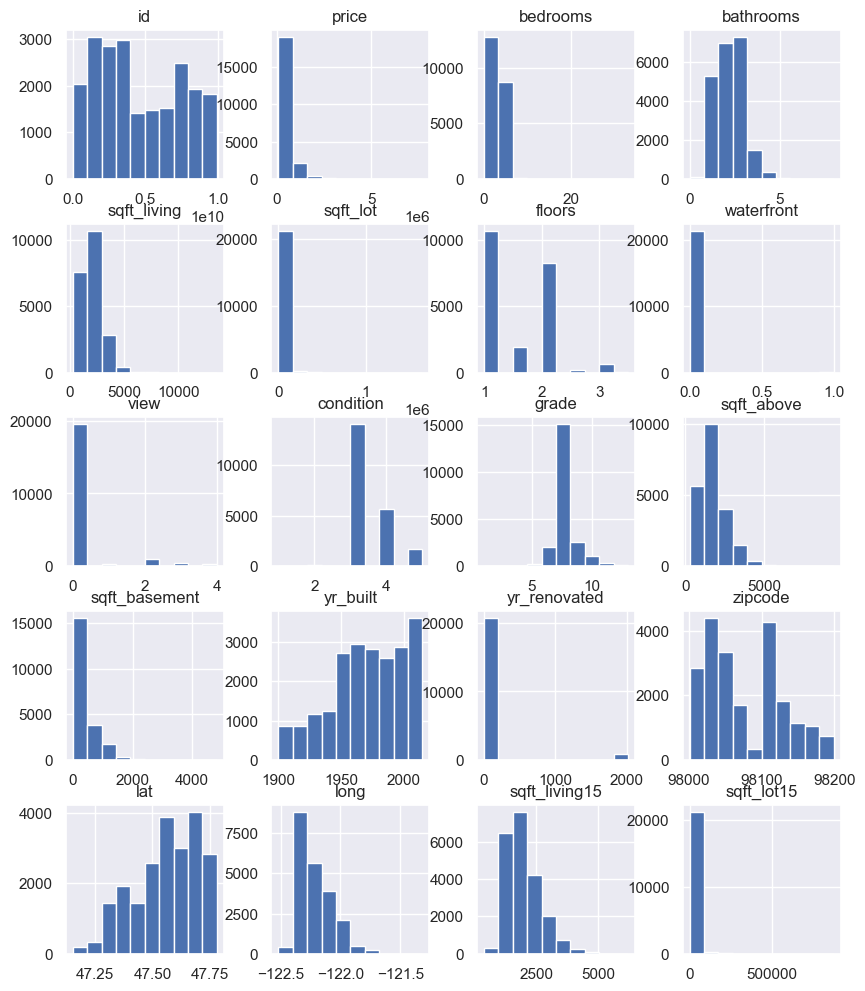

In [23]:
num_attributes.hist(figsize=(10, 12));

#### Considerations from Numerical Atributes

- The number of bathrooms is not in integer values, as would be expected. The dataset includes information such as 0.75 bathrooms or 1.25 bathrooms.
- There is a house with 33 bedrooms, but the maximum number of bathrooms is 8.
- Some houses don't have bedrooms.
- Some houses don't have bathrooms.
- Some houses have neither bedrooms nor bathrooms.

### Categorical Atributes

In [24]:
cat_attributes.apply( lambda x: x.unique().shape[0] )

Series([], dtype: float64)

# STEP 02 - FEATURE ENGINEERING

In [35]:
df2 = df1.copy()

In [36]:
# year
df2['yr_built'] = df2['date'].dt.year
df2['yr_renovated'] = df2['date'].dt.year

In [37]:
# sales year
df2['year_sales'] = df2['date'].dt.year

# sales month
df2['month_sales'] = df2['date'].dt.month

# day
df2['day_of_year_sales'] = df2['date'].dt.day

In [28]:
#df2.head()

# STEP 03 - DATA FILTERING

In [38]:
df3 = df2.copy()

## Discrepancies in Bedrooms and Bathrooms

In [39]:
len(df3[df3['bedrooms'] > 15])

1

In [40]:
# Excluding the house with 33 bedrooms
df3 = df3[df3['bedrooms'] <= 15]

In [41]:
# Excluding the houses without bathrooms and the houses without bedrooms
df3 = df3[(df3['bedrooms'] != 0) & (df3['bathrooms'] != 0)]

In American real estate, bathroom counts are sometimes expressed as fractions, like 0.75 or 1.25. Unlike whole numbers, this approach provides a more detailed description of the bathroom facilities. For example, 0.75 might mean a bathroom with a shower and sink. It's a unique aspect of how Americans convey property information, allowing for a more nuanced understanding of the amenities offered in a home.

# STEP 04 - EXPLORATORY DATA ANALYSIS

In [42]:
'''# Substituir os pontos por vírgulas
# Substituir os pontos por vírgulas nas colunas float
df3['lat'] = df3['lat'].apply(lambda x: str(x).replace('.', ','))
df3['long'] = df3['long'].apply(lambda x: str(x).replace('.', ','))
df3['bathrooms'] = df3['bathrooms'].apply(lambda x: str(x).replace('.', ','))
df3['floors'] = df3['floors'].apply(lambda x: str(x).replace('.', ','))
'''

In [43]:
'''# Caminho para a pasta onde você deseja salvar o arquivo CSV
caminho_pasta = 'C:/Users/prisc/OneDrive/Documentos/Dados/Analise_dados/data'

# Nome do arquivo CSV que você deseja salvar
nome_arquivo = 'dataset_virgula.csv'

# Caminho completo para o arquivo CSV
caminho_arquivo = caminho_pasta + '/' + nome_arquivo

# Salvar o DataFrame como um arquivo CSV
df3.to_csv(caminho_arquivo, index=False)

print(f"O arquivo {nome_arquivo} foi salvo em {caminho_pasta}.")'''

O arquivo dataset_virgula.csv foi salvo em C:/Users/prisc/OneDrive/Documentos/Dados/Analise_dados/data.


In [33]:
df4 = df3.copy()

In [34]:
report = sv.analyze (df4, target_feat='price')
report.show_html(filepath='../reports/sweetviz_report.html', open_browser=False)

                                             |          | [  0%]   00:00 -> (? left)

Report ../reports/sweetviz_report.html was generated.



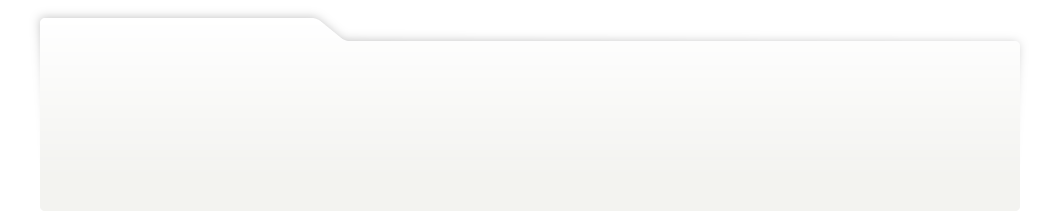
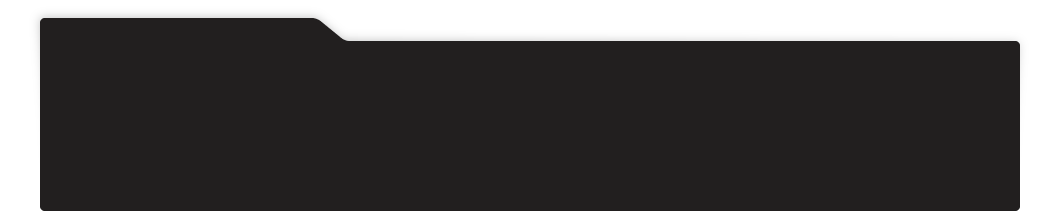
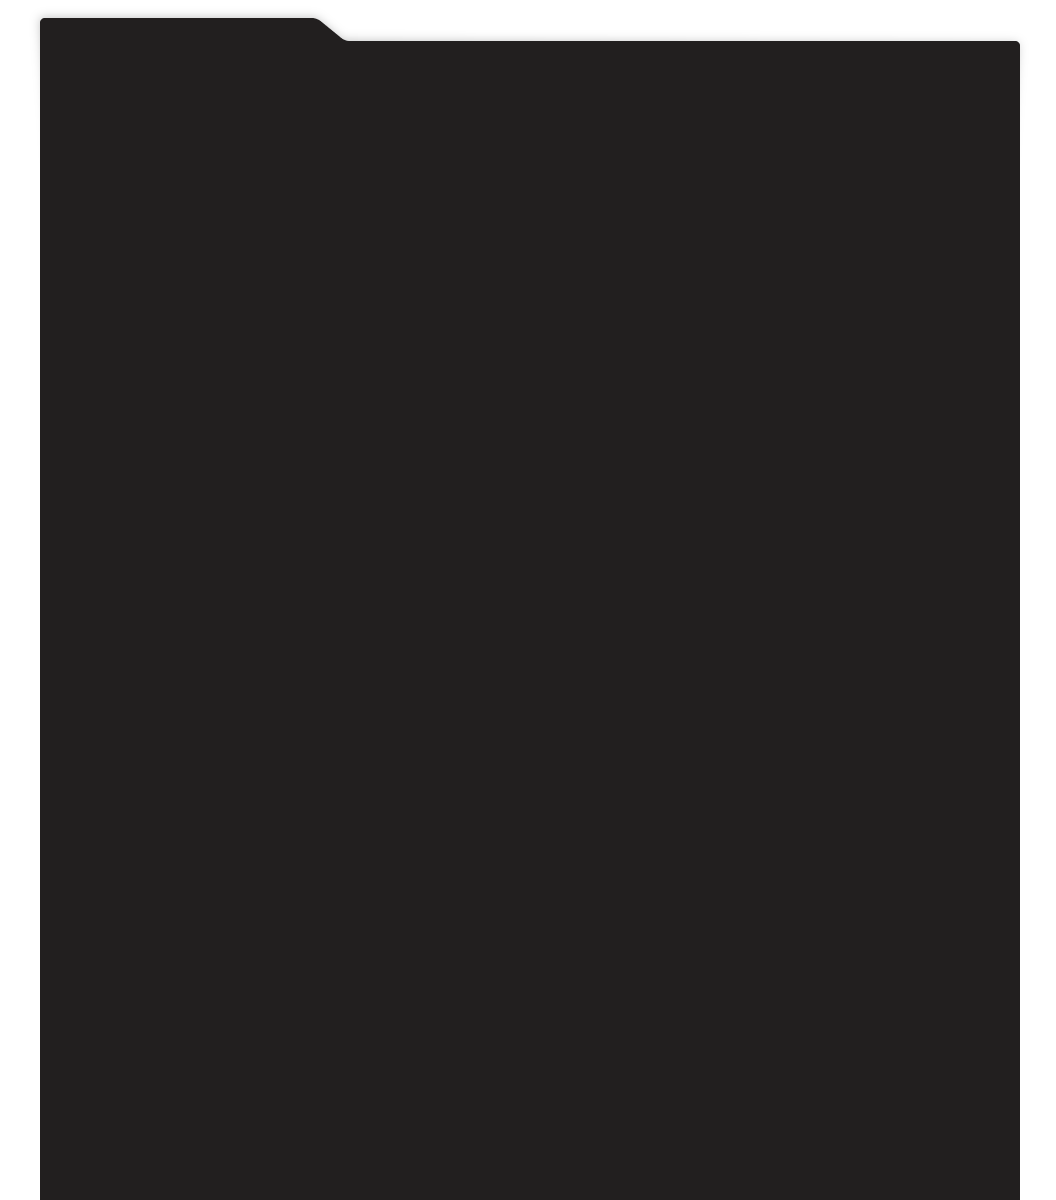
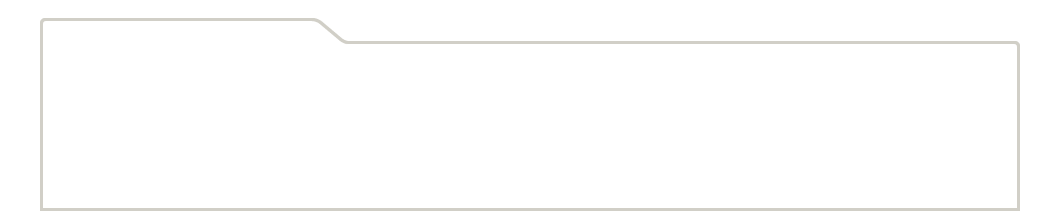
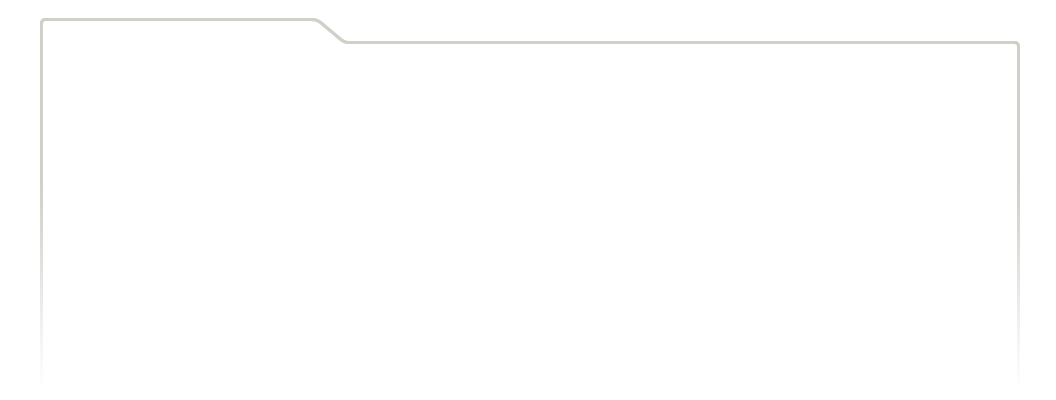
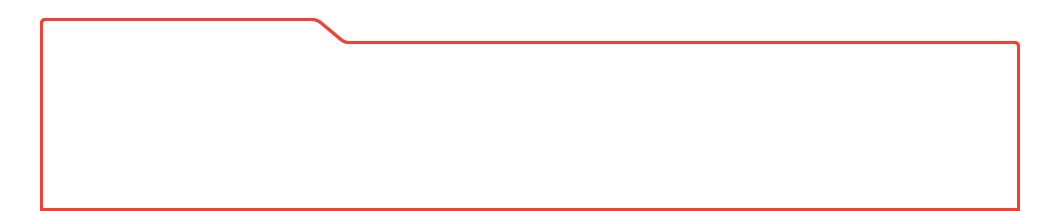
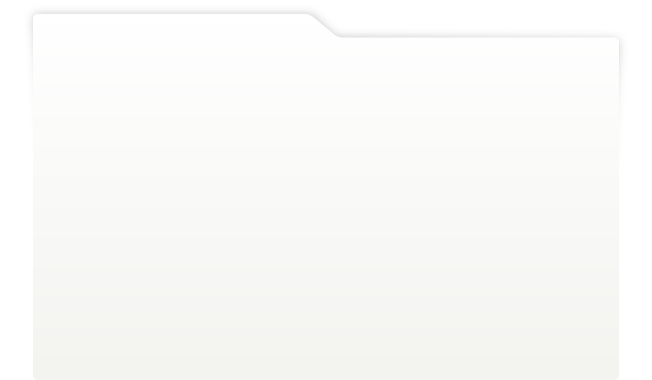
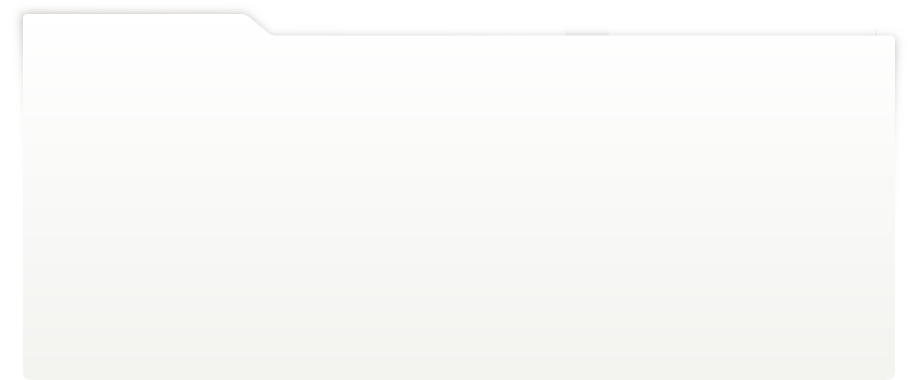
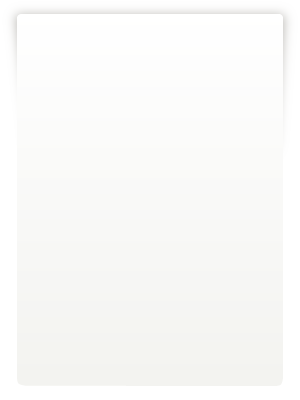
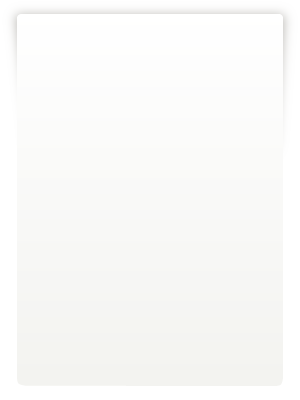
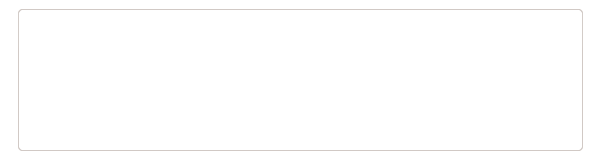
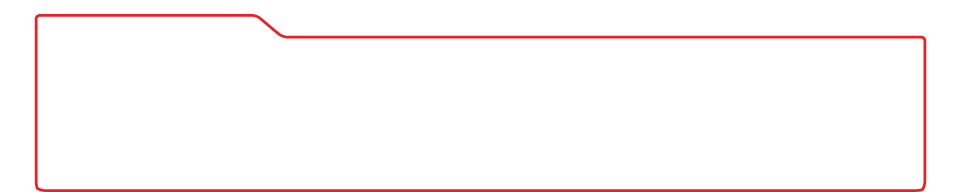
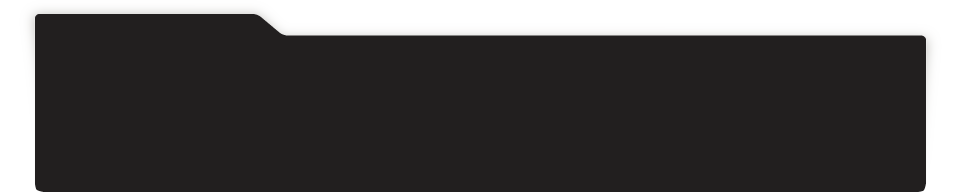
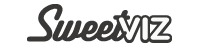
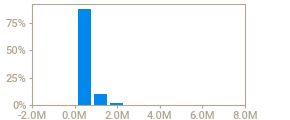
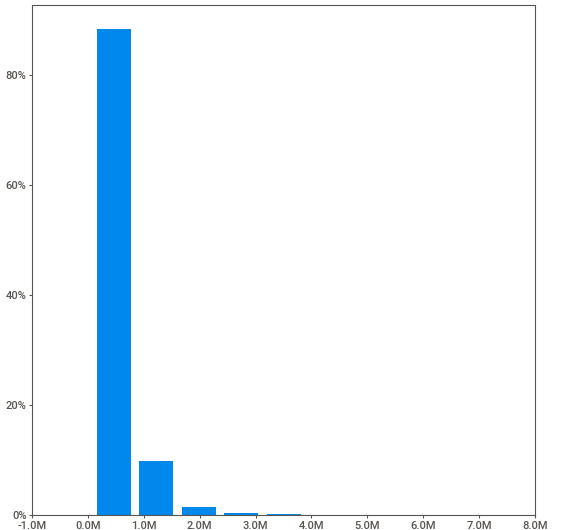
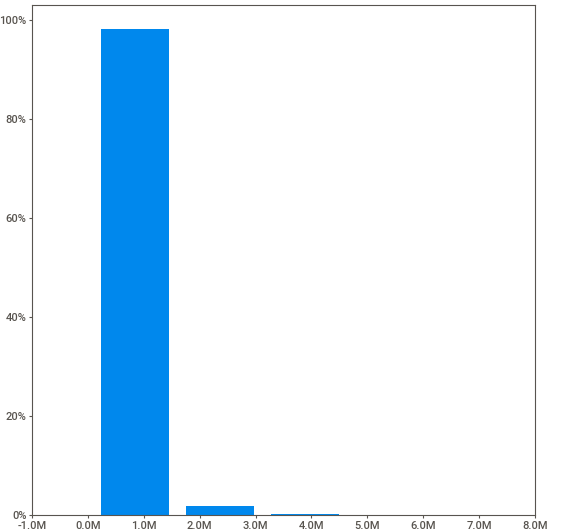
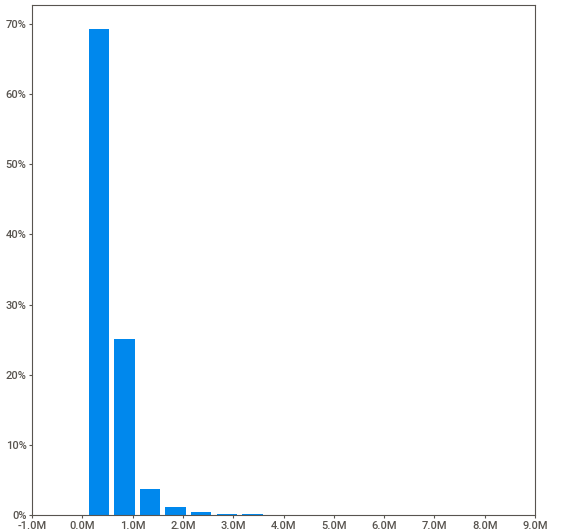
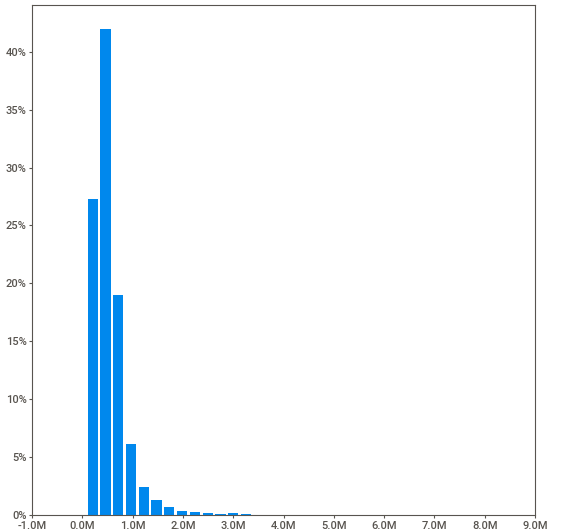
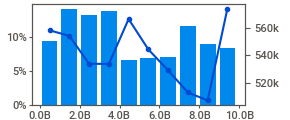
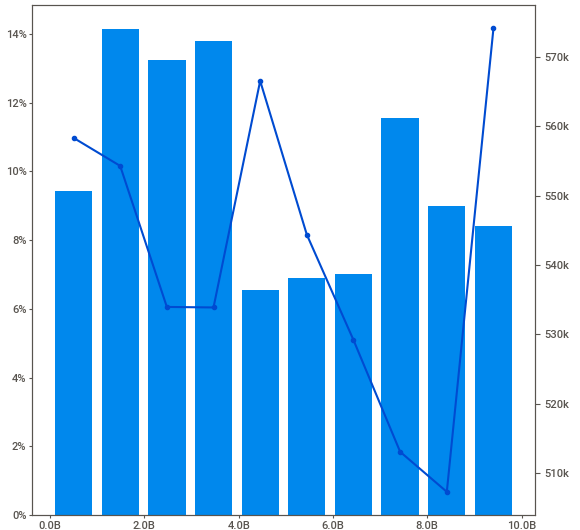
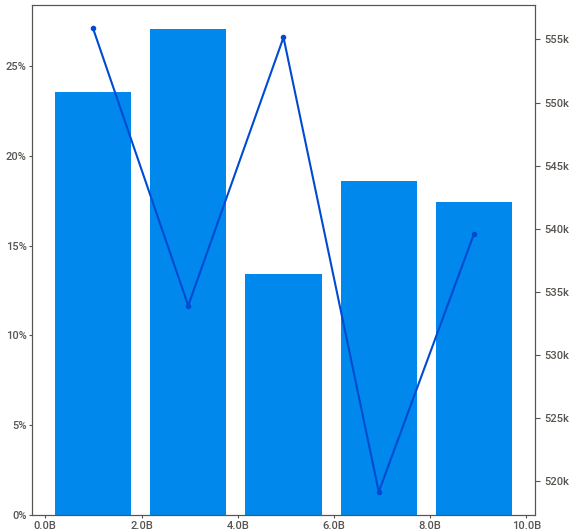
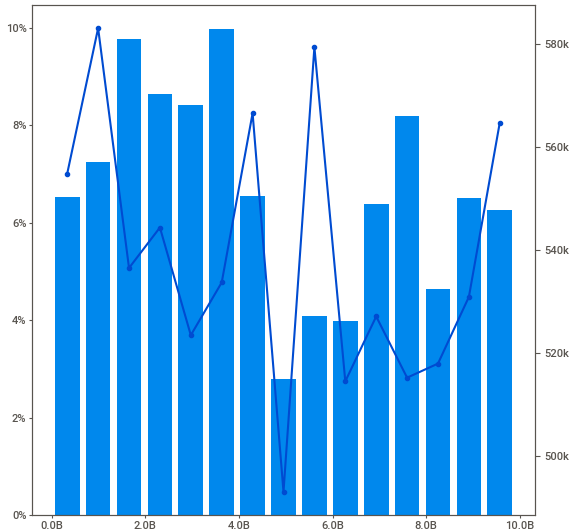
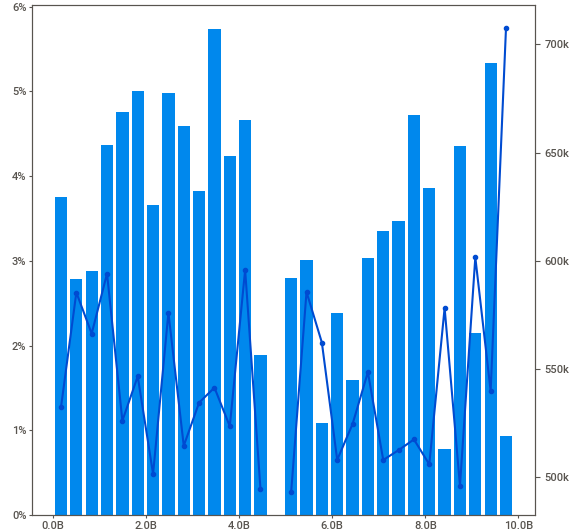
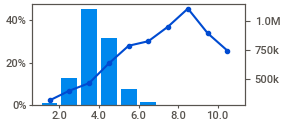
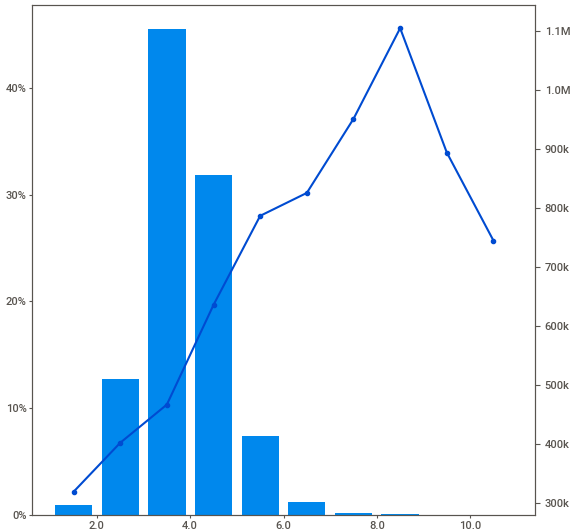
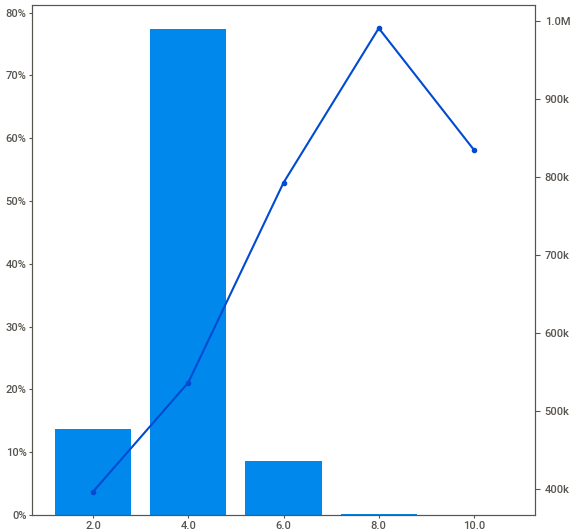
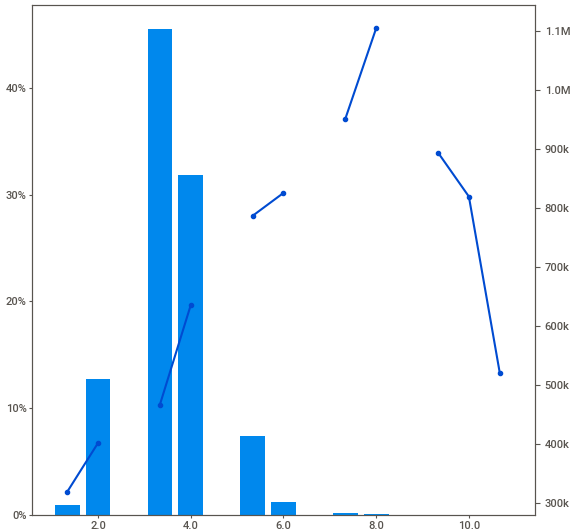
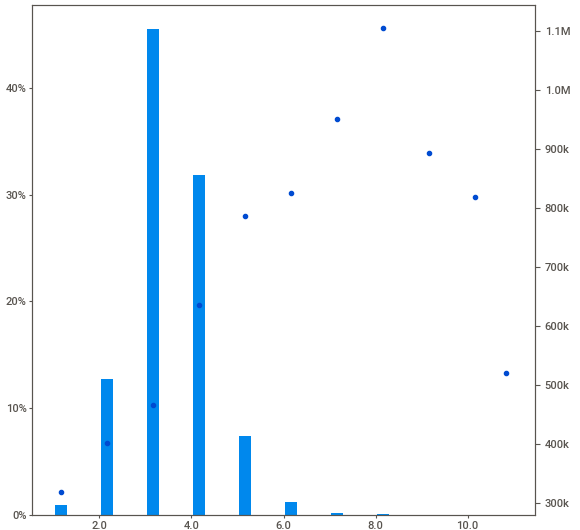
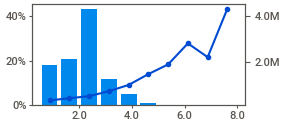
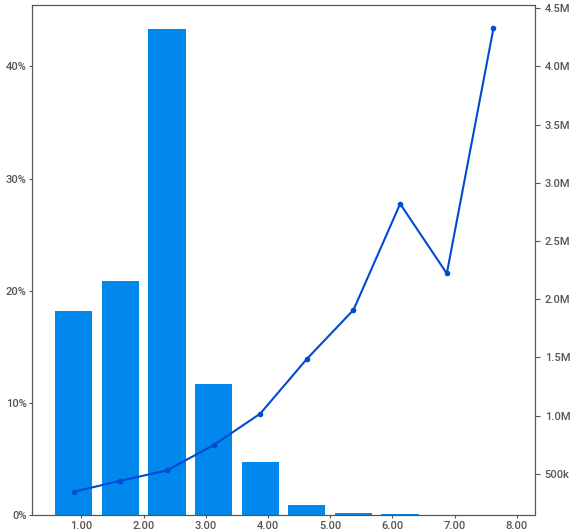
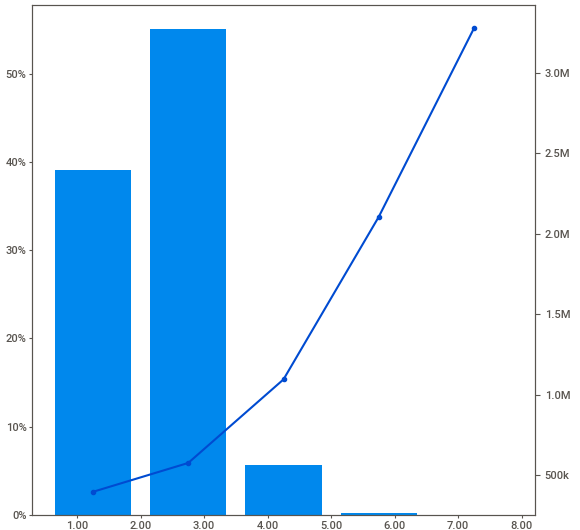
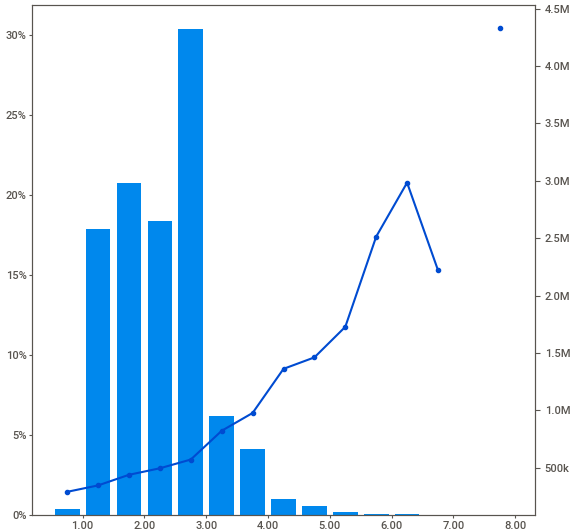
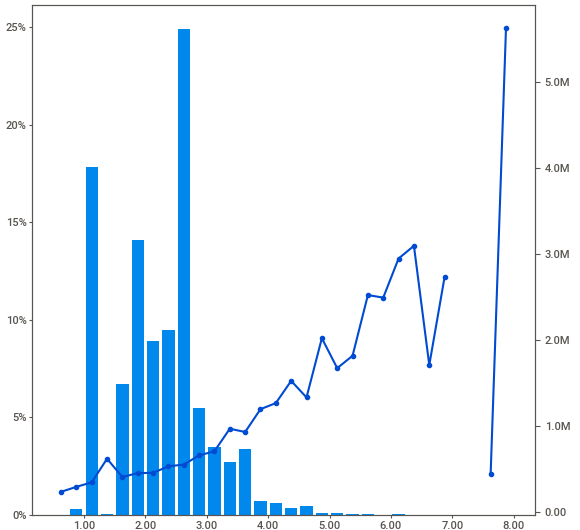
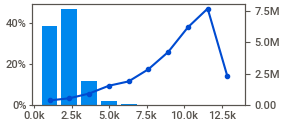
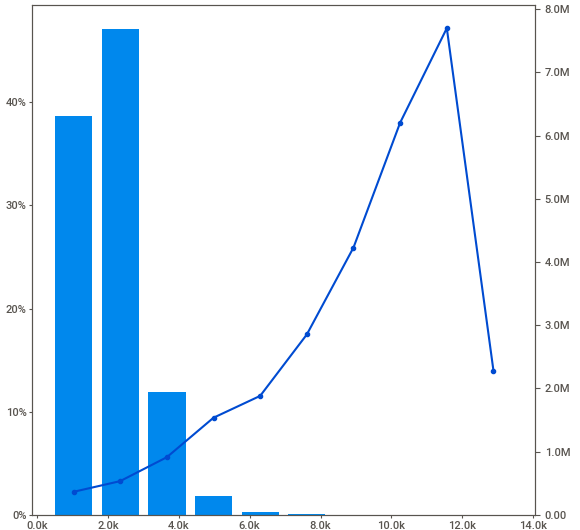
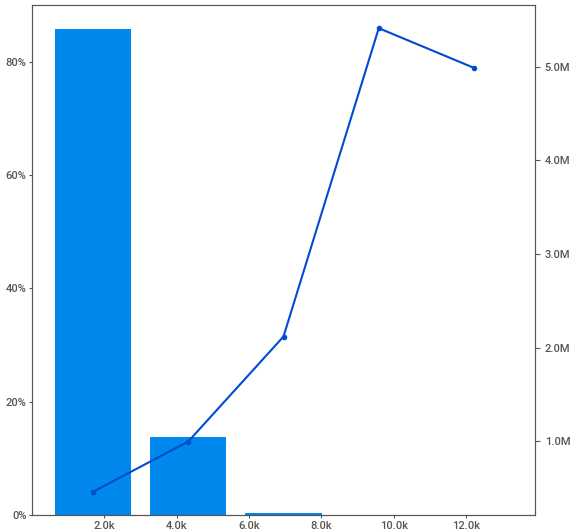
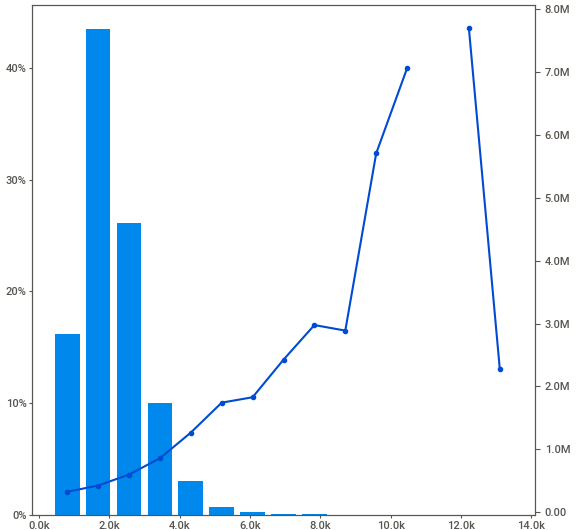
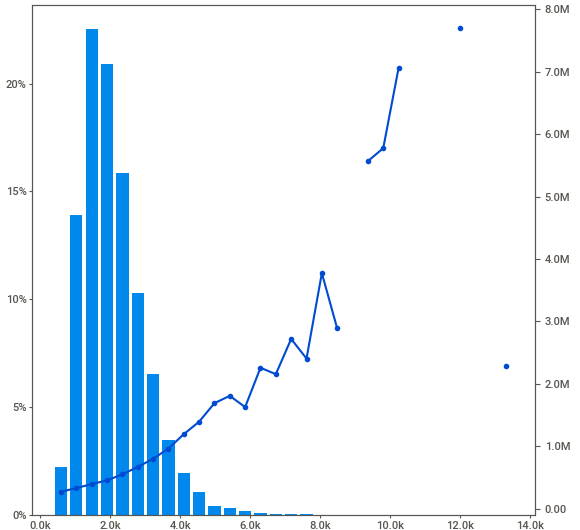
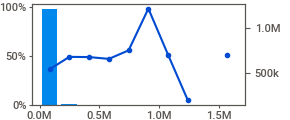
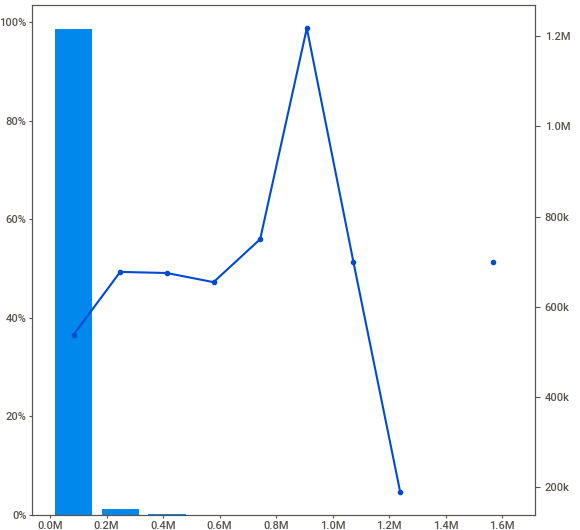
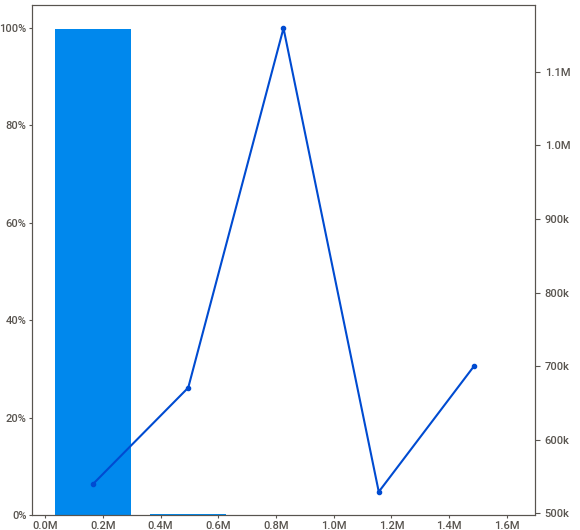
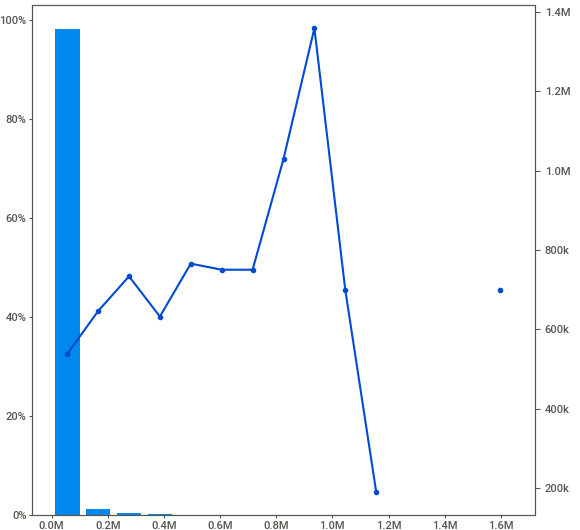
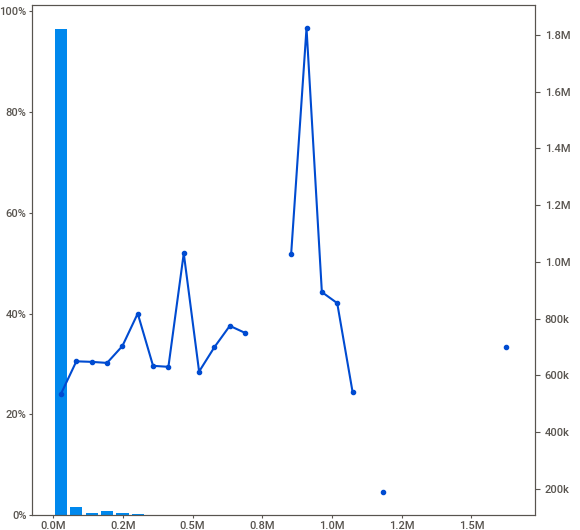
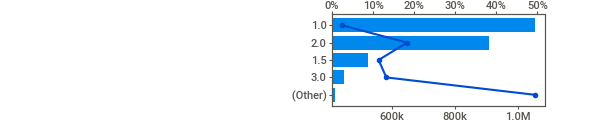
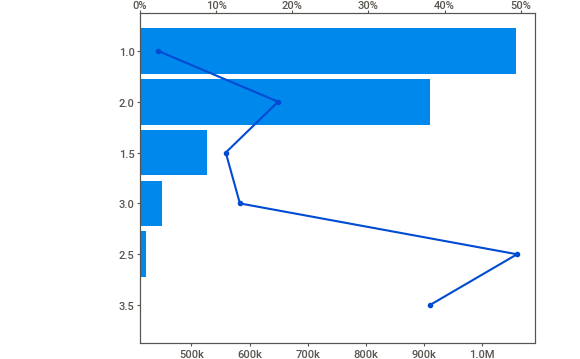
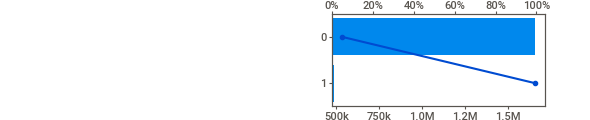
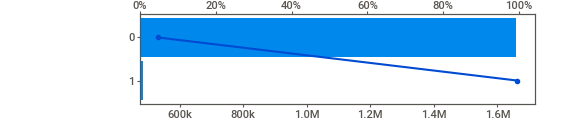
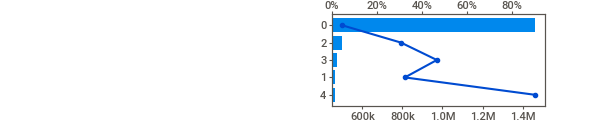
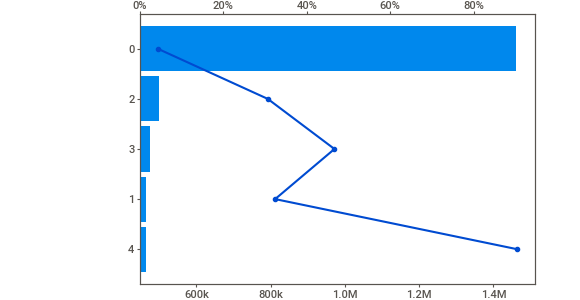
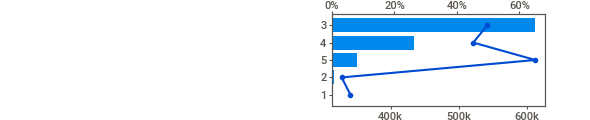
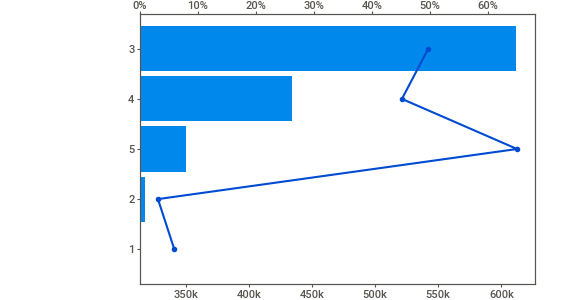
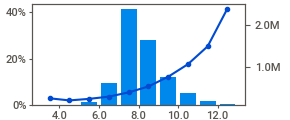
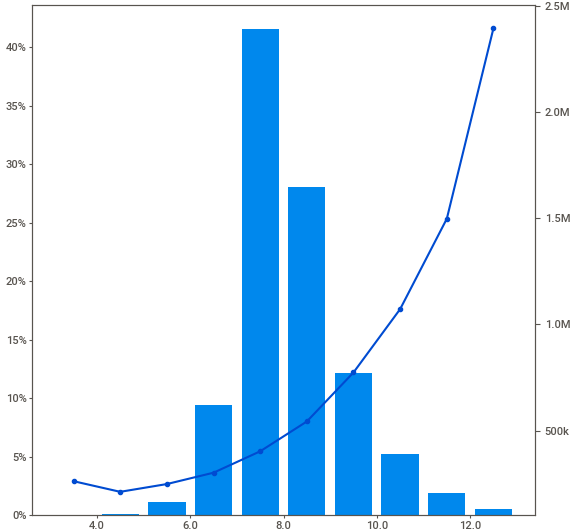
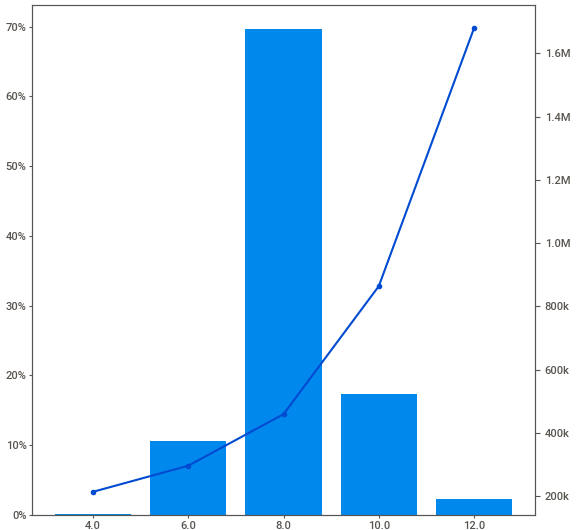
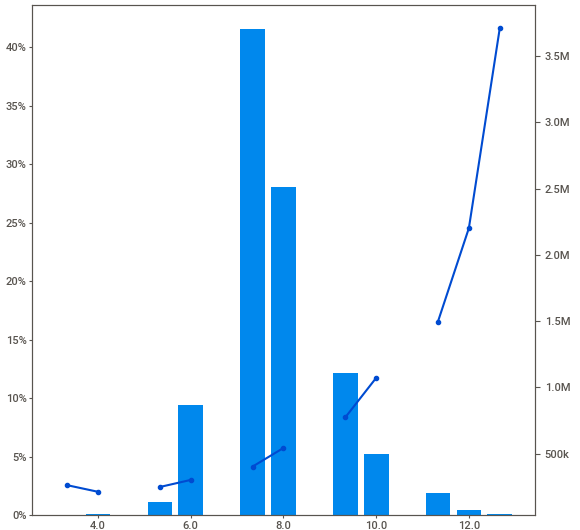
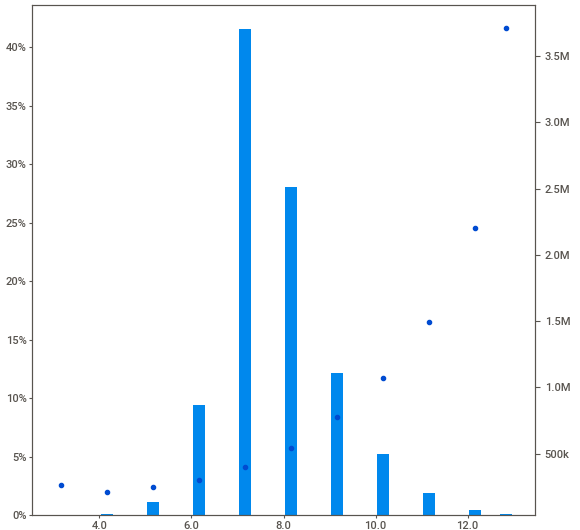
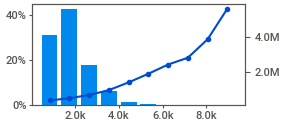
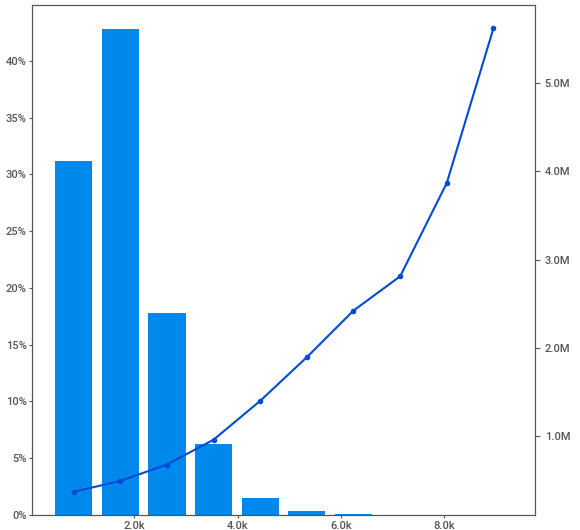
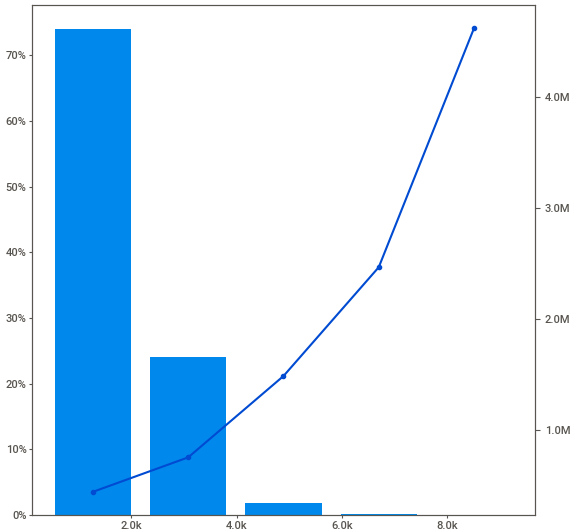
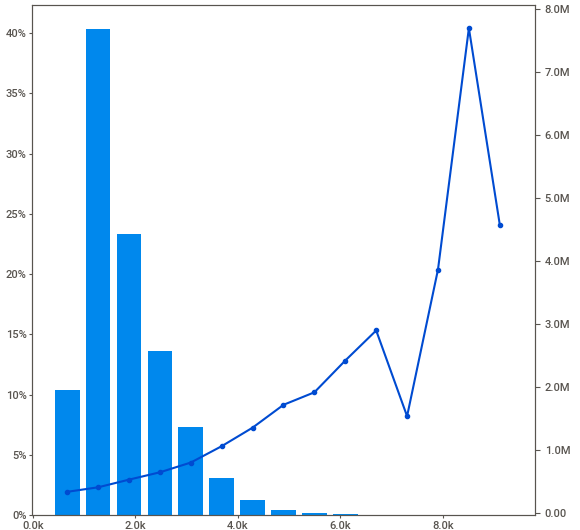
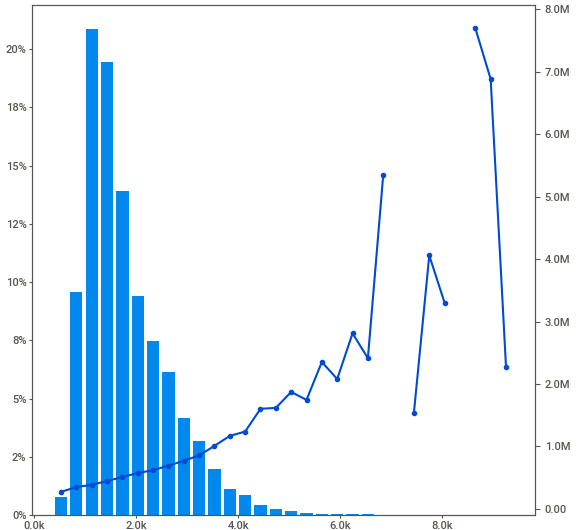
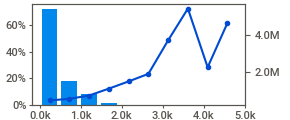
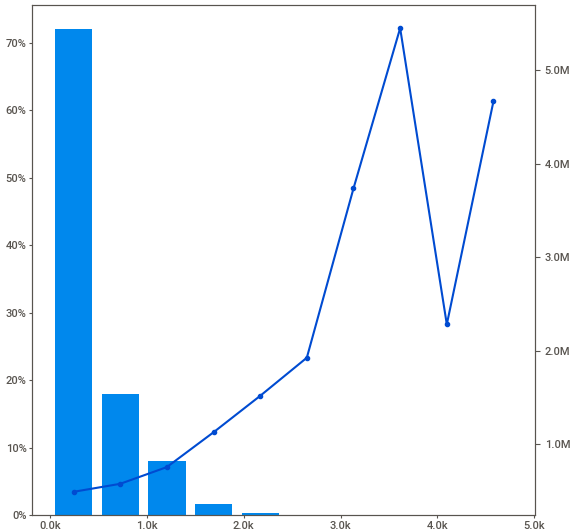
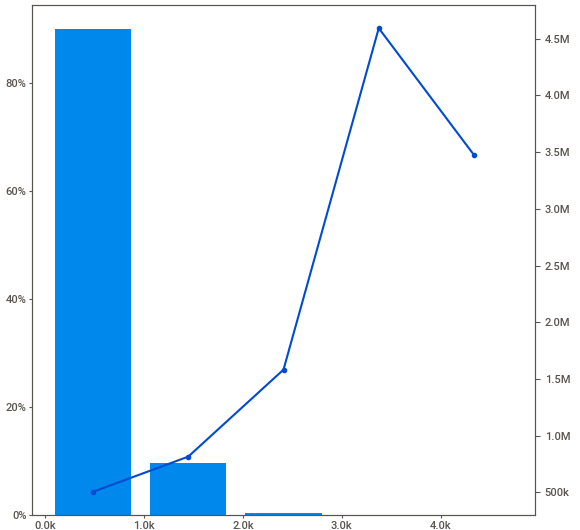
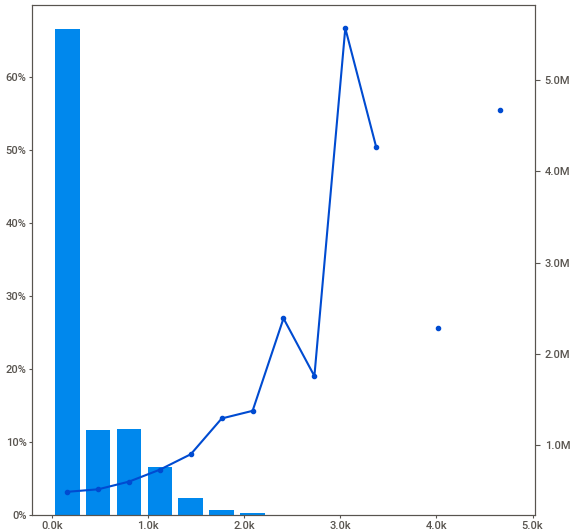
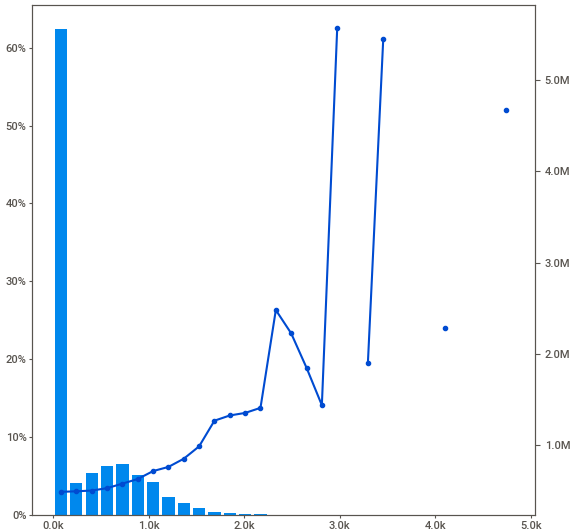
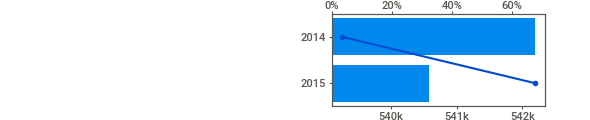
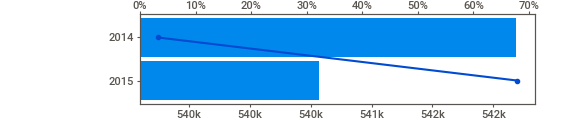
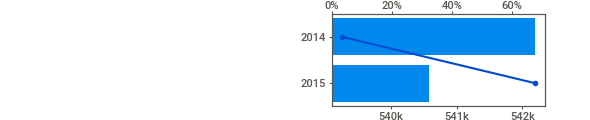
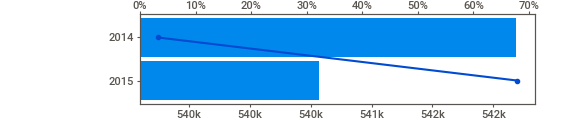
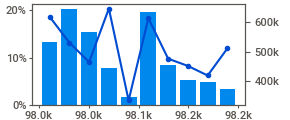
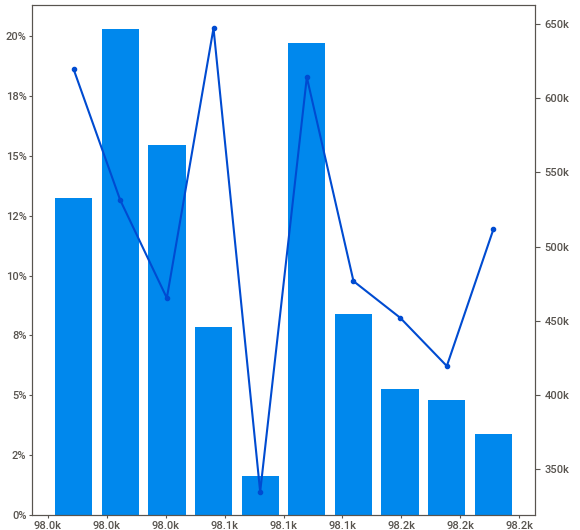
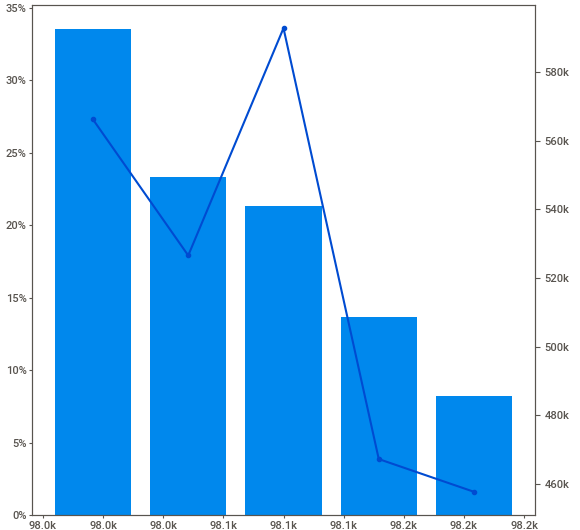
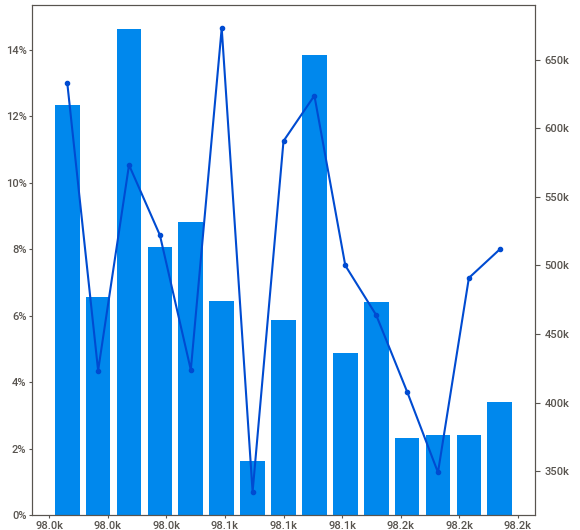
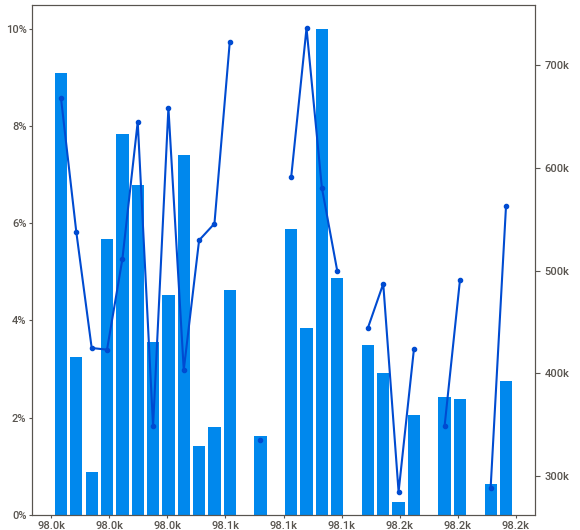
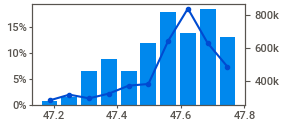
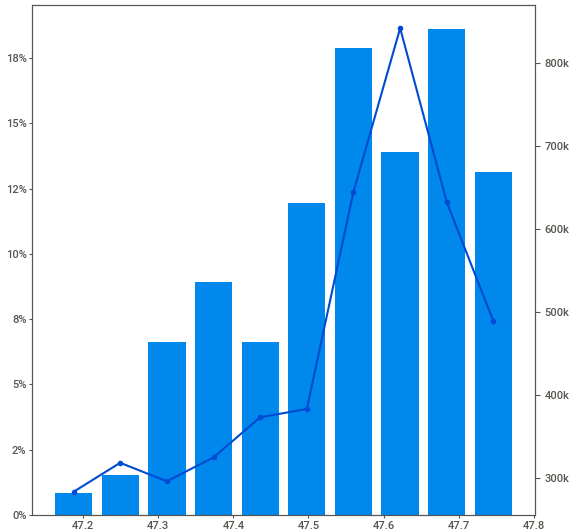
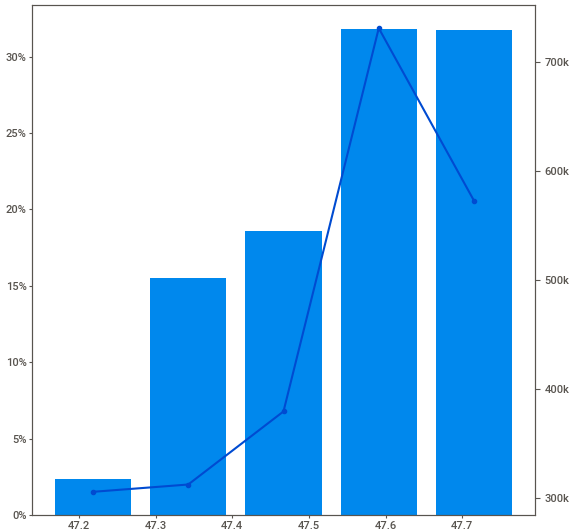
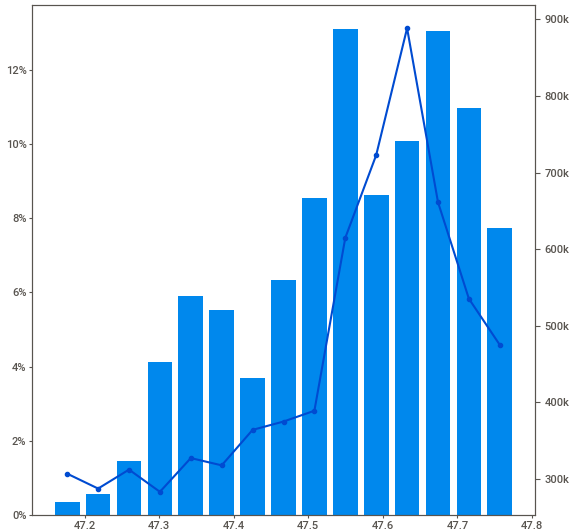
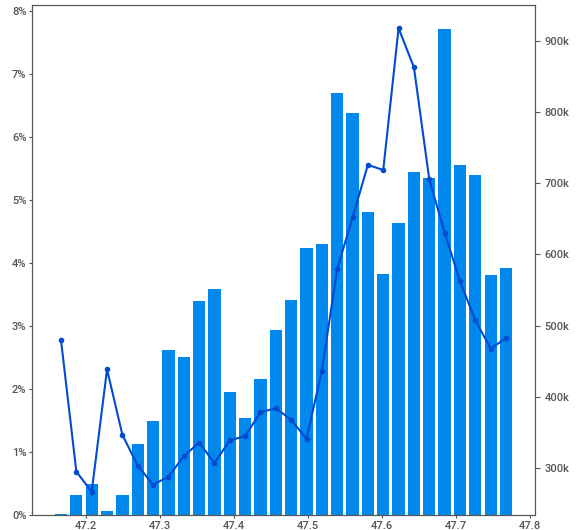
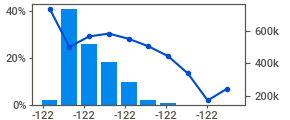
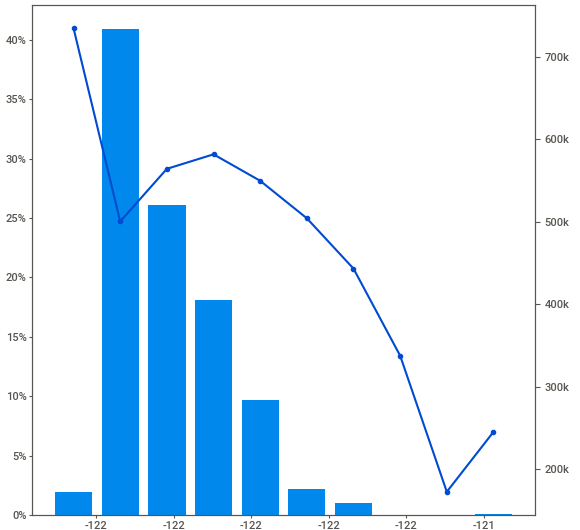
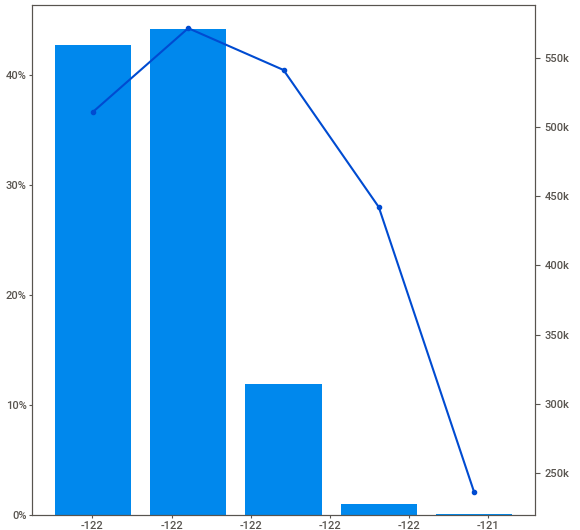
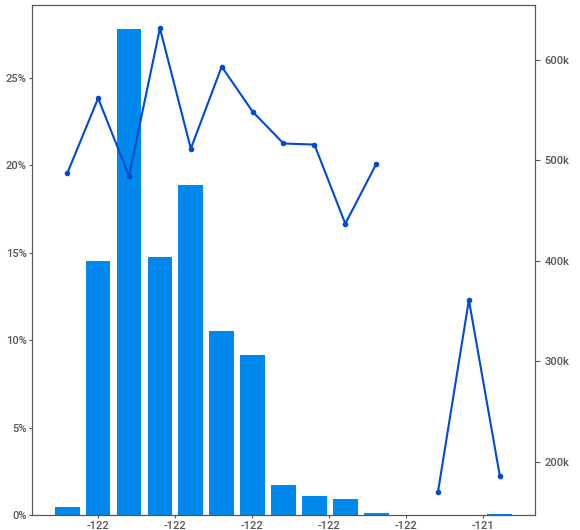
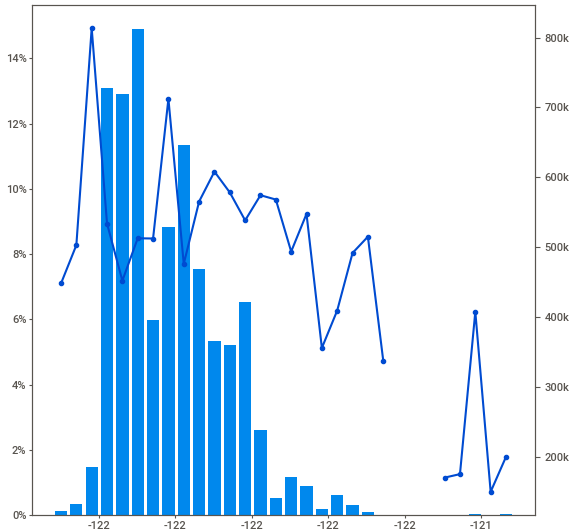
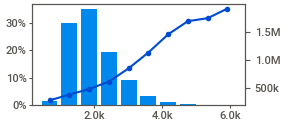
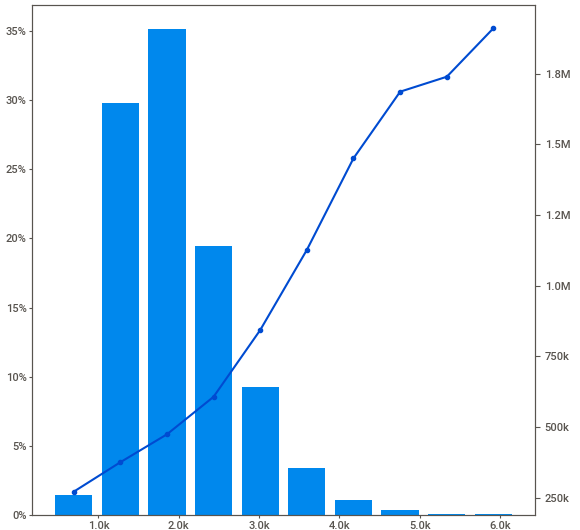
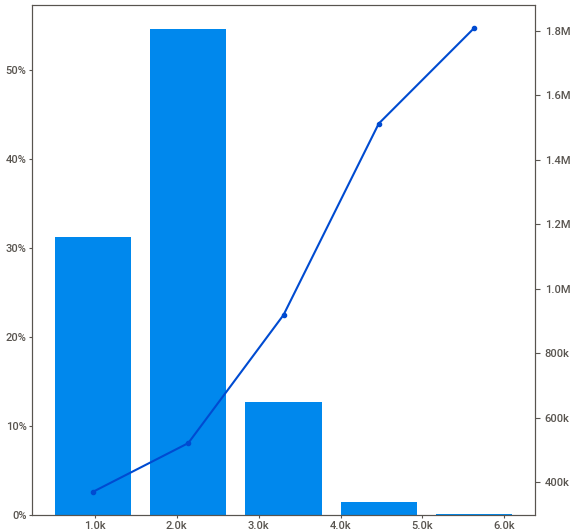
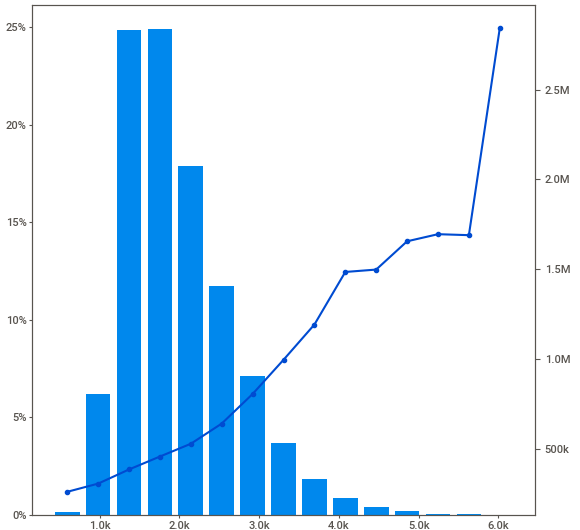
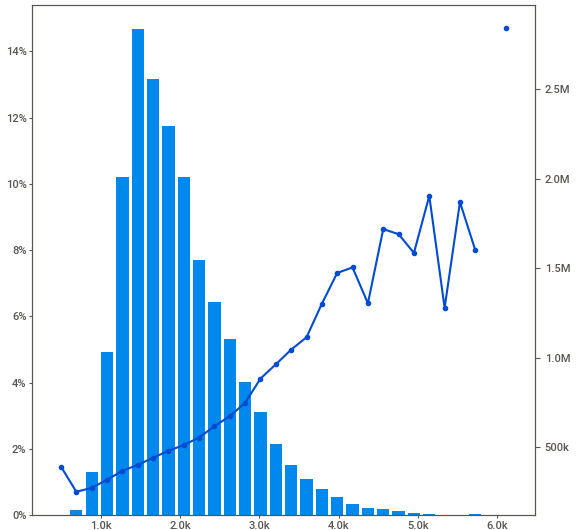
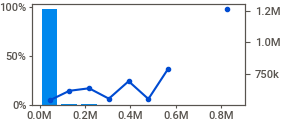
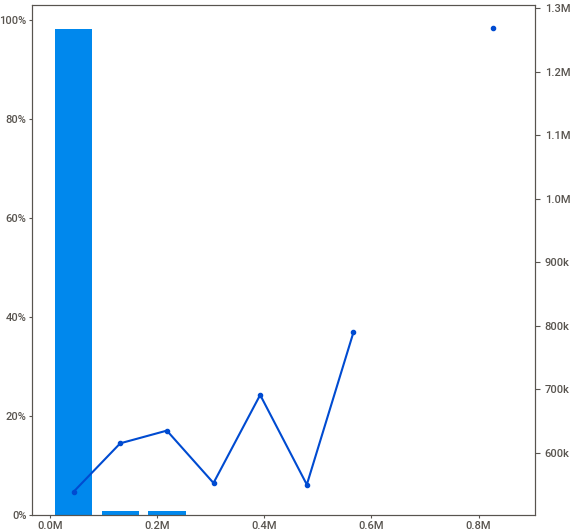
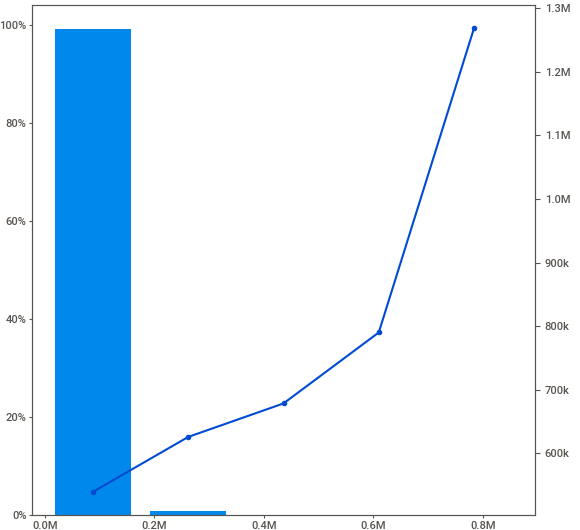
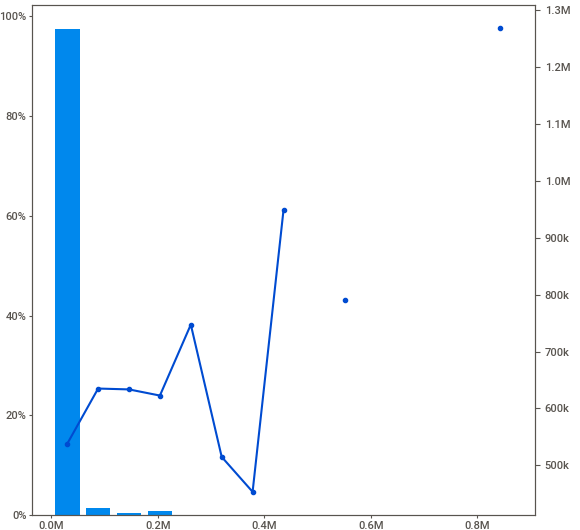
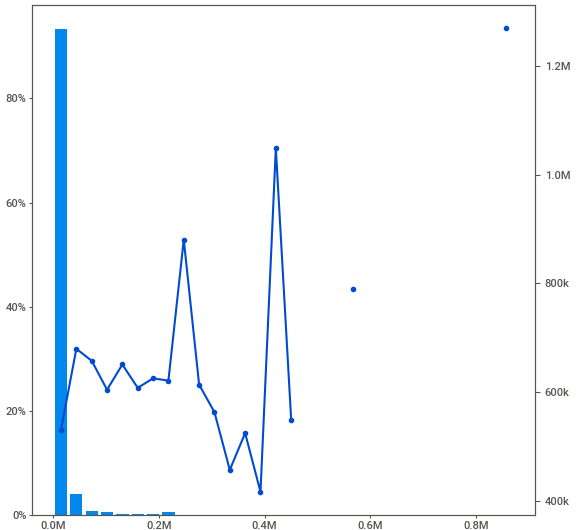
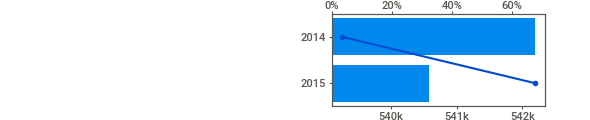
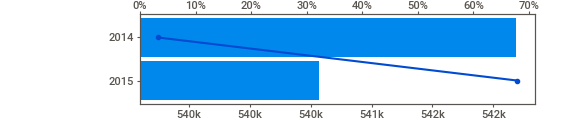
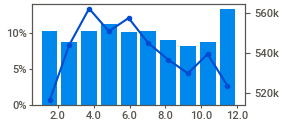
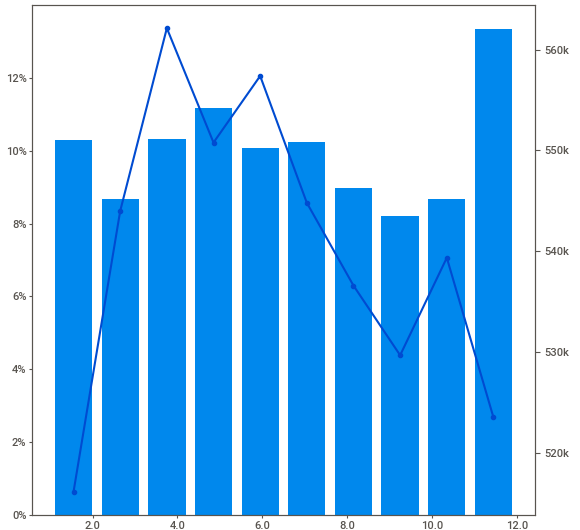
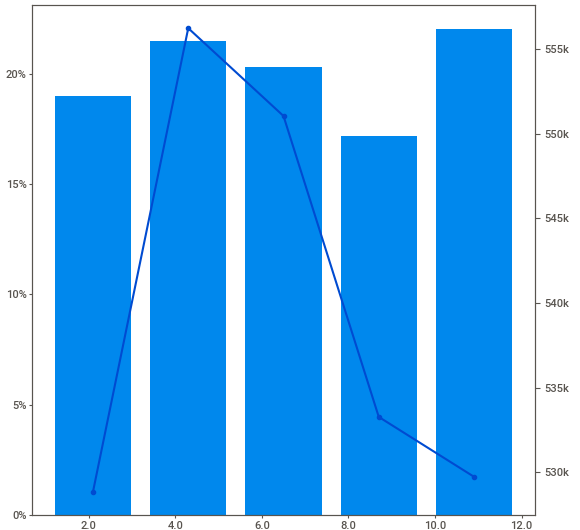
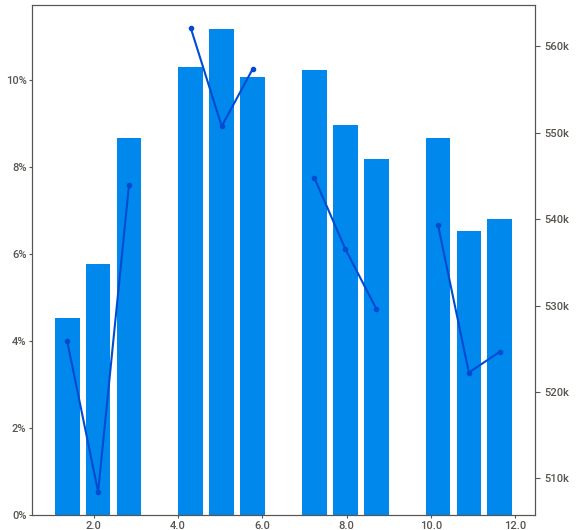
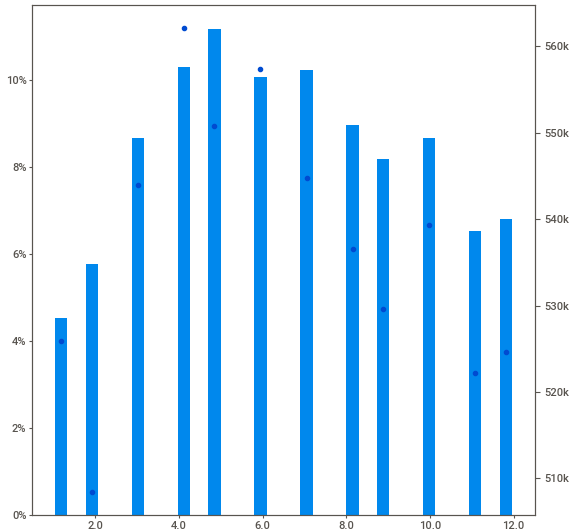
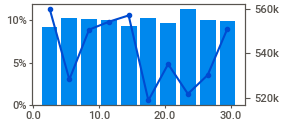
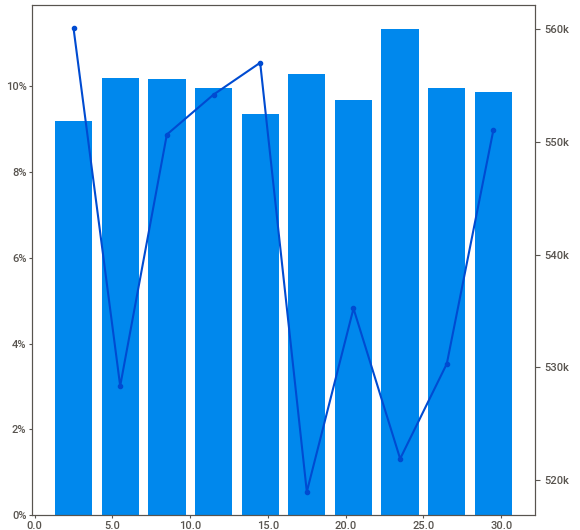
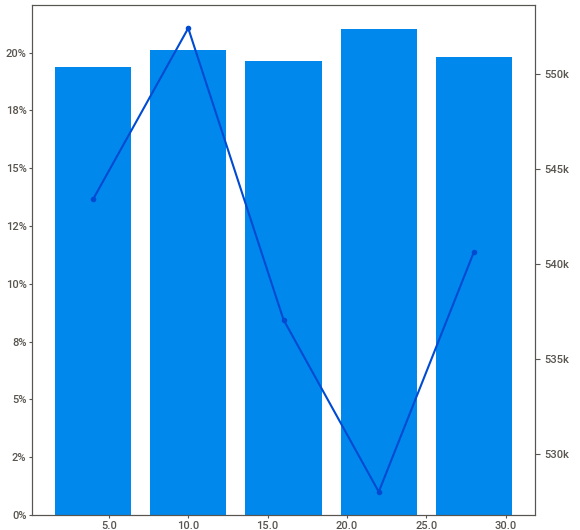
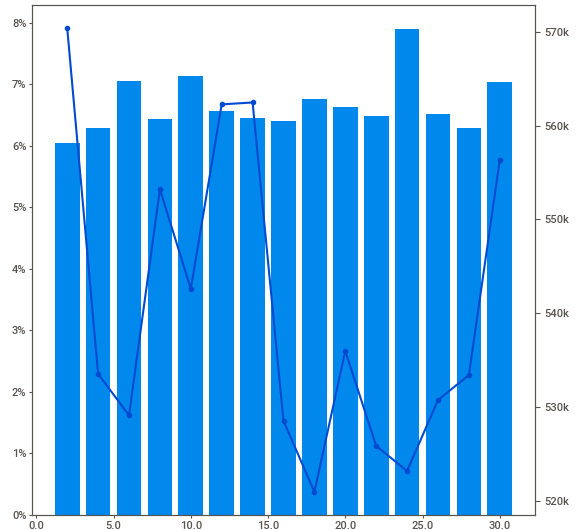
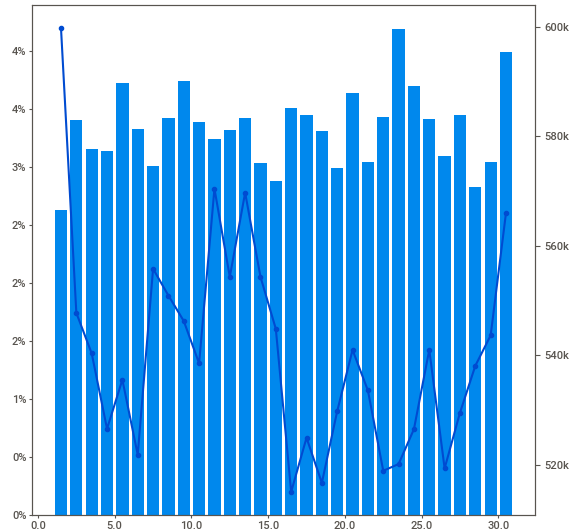
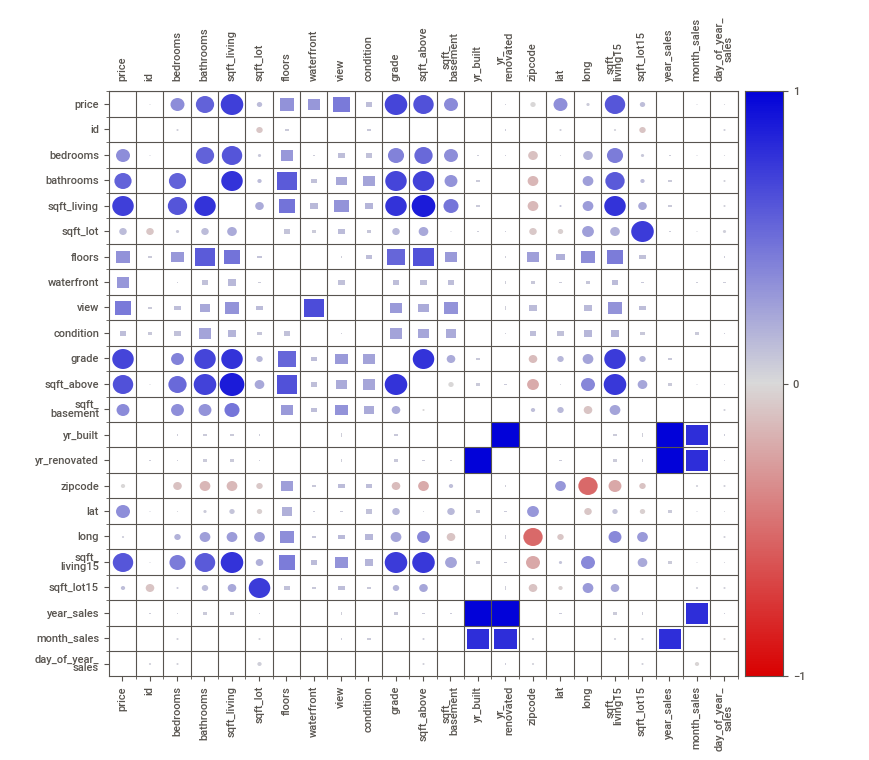
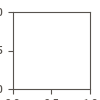

In [35]:
#display on the notebook
report.show_notebook(w=None, h=None, scale=None, layout='vertical')

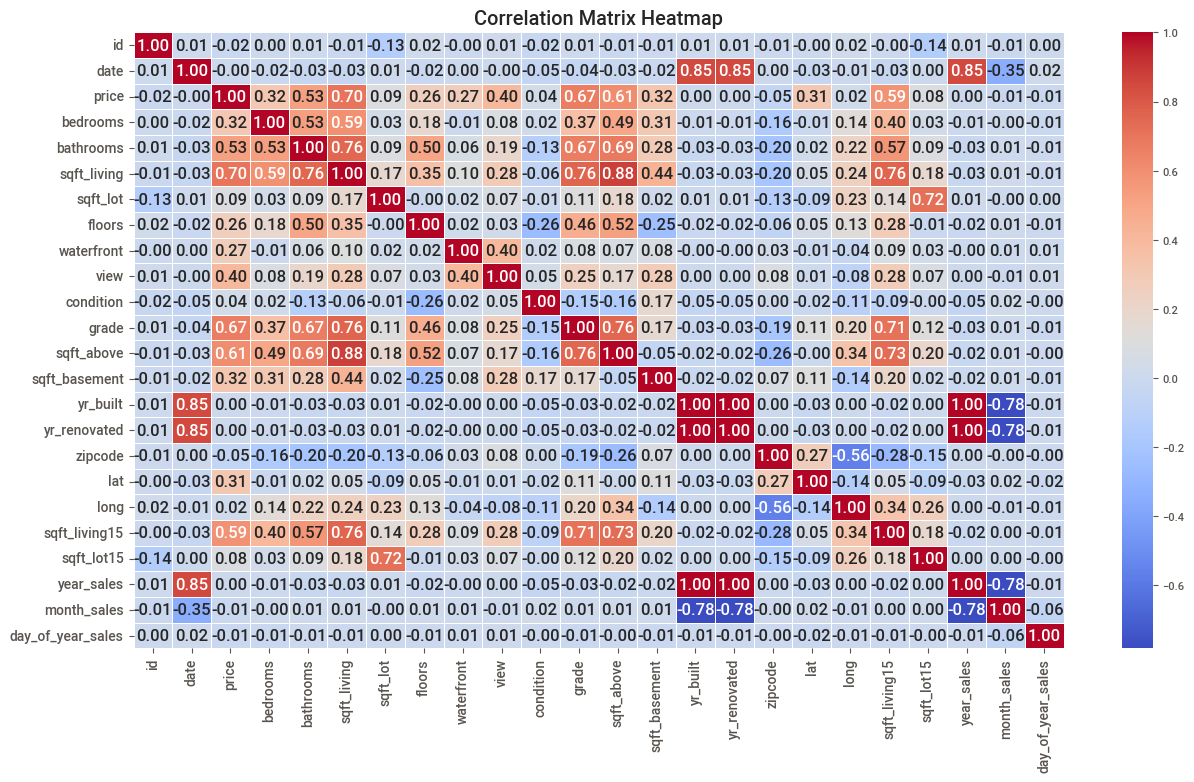

In [36]:
# Calculate the correlation matrix
correlation_matrix = df4.corr()

# Set up the matplotlib figure
plt.figure(figsize=(15, 8))

# Create a heatmap 
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)

# Customize 
plt.title('Correlation Matrix Heatmap')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.savefig('../reports/'+ 'correlation_matrix')

# Show 
plt.show()

## Considerations from EDA

- Houses with more bathrooms are more expensive. (not true)
- Houses with more bedrooms are more expensive.  (not true)
- Houses with a better view have a higher price.
- Houses with higher construction quality have a higher price.
- Houses with a larger living area in square feet are more expensive.
- Houses in better condition are more expensive.

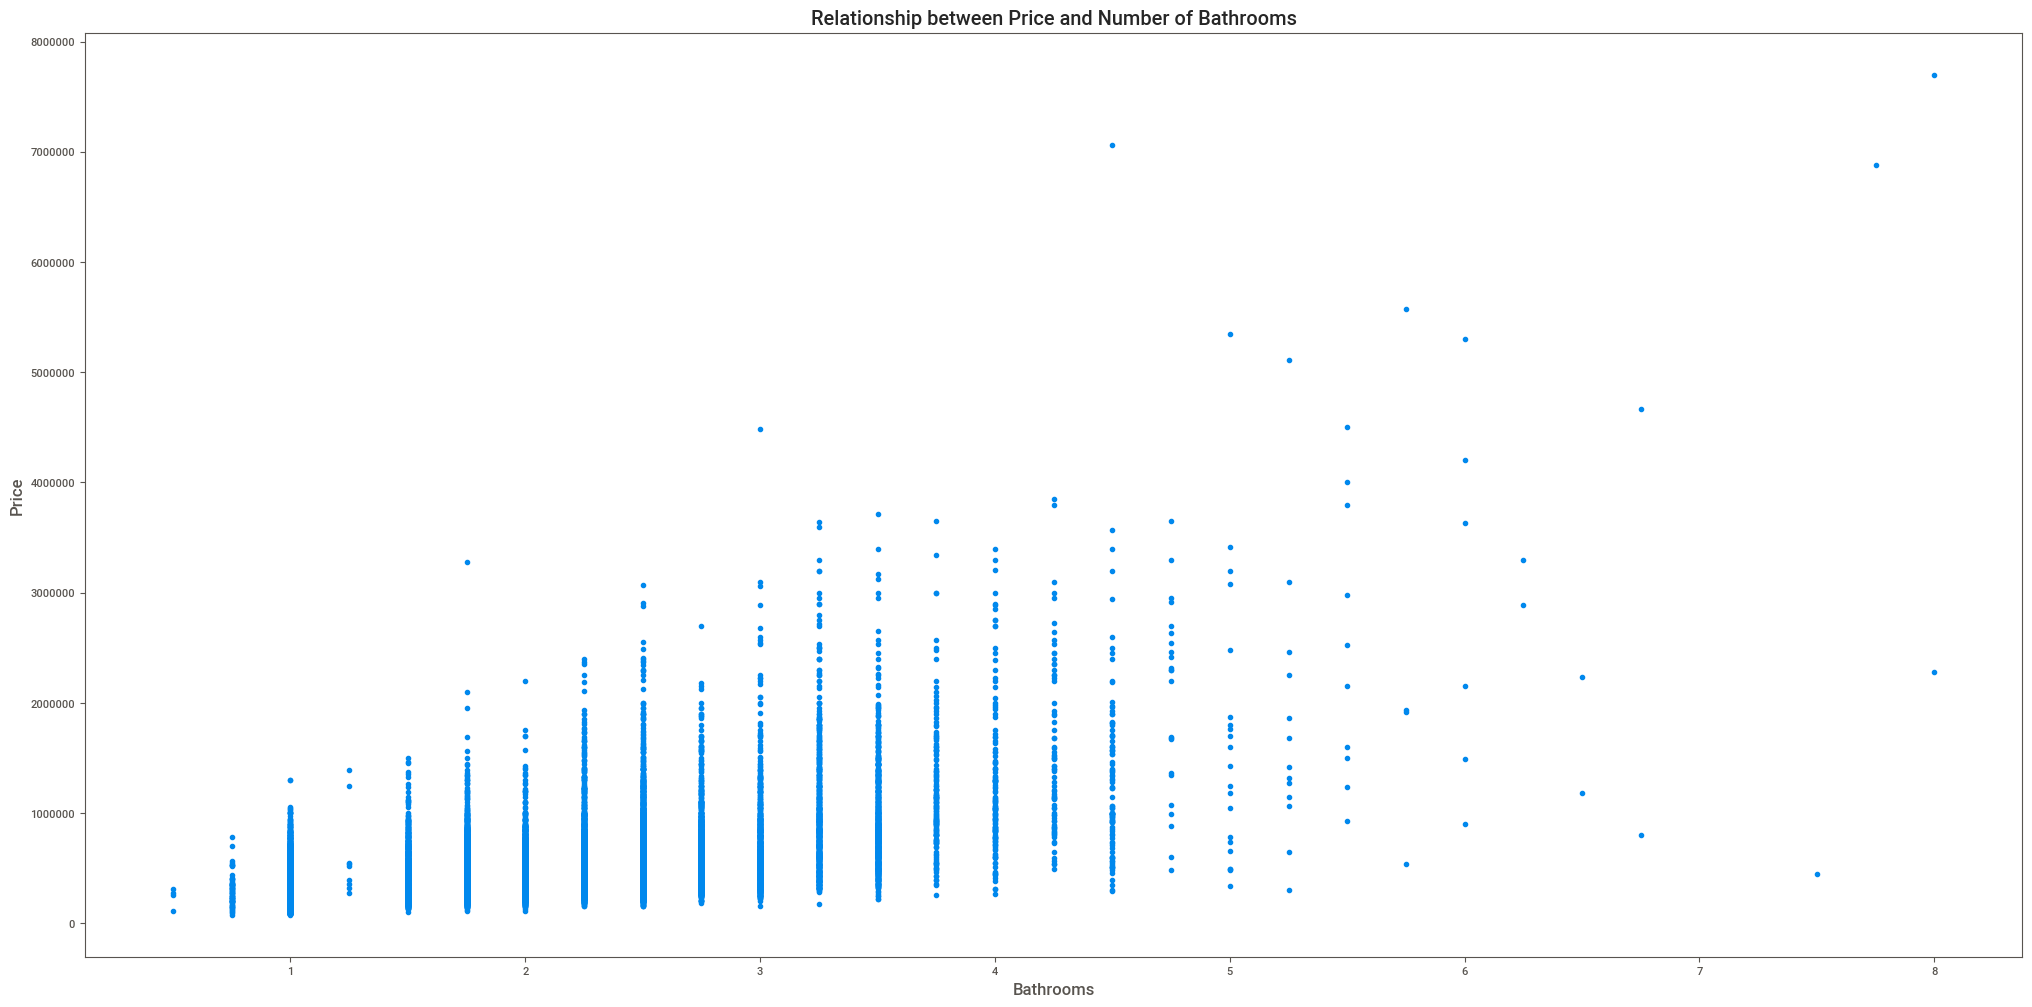

In [37]:
ax = plt.scatter(df4['bathrooms'], df4['price'])

# Labels
plt.xlabel('Bathrooms')
plt.ylabel('Price')
plt.title('Relationship between Price and Number of Bathrooms')

# show
plt.show()

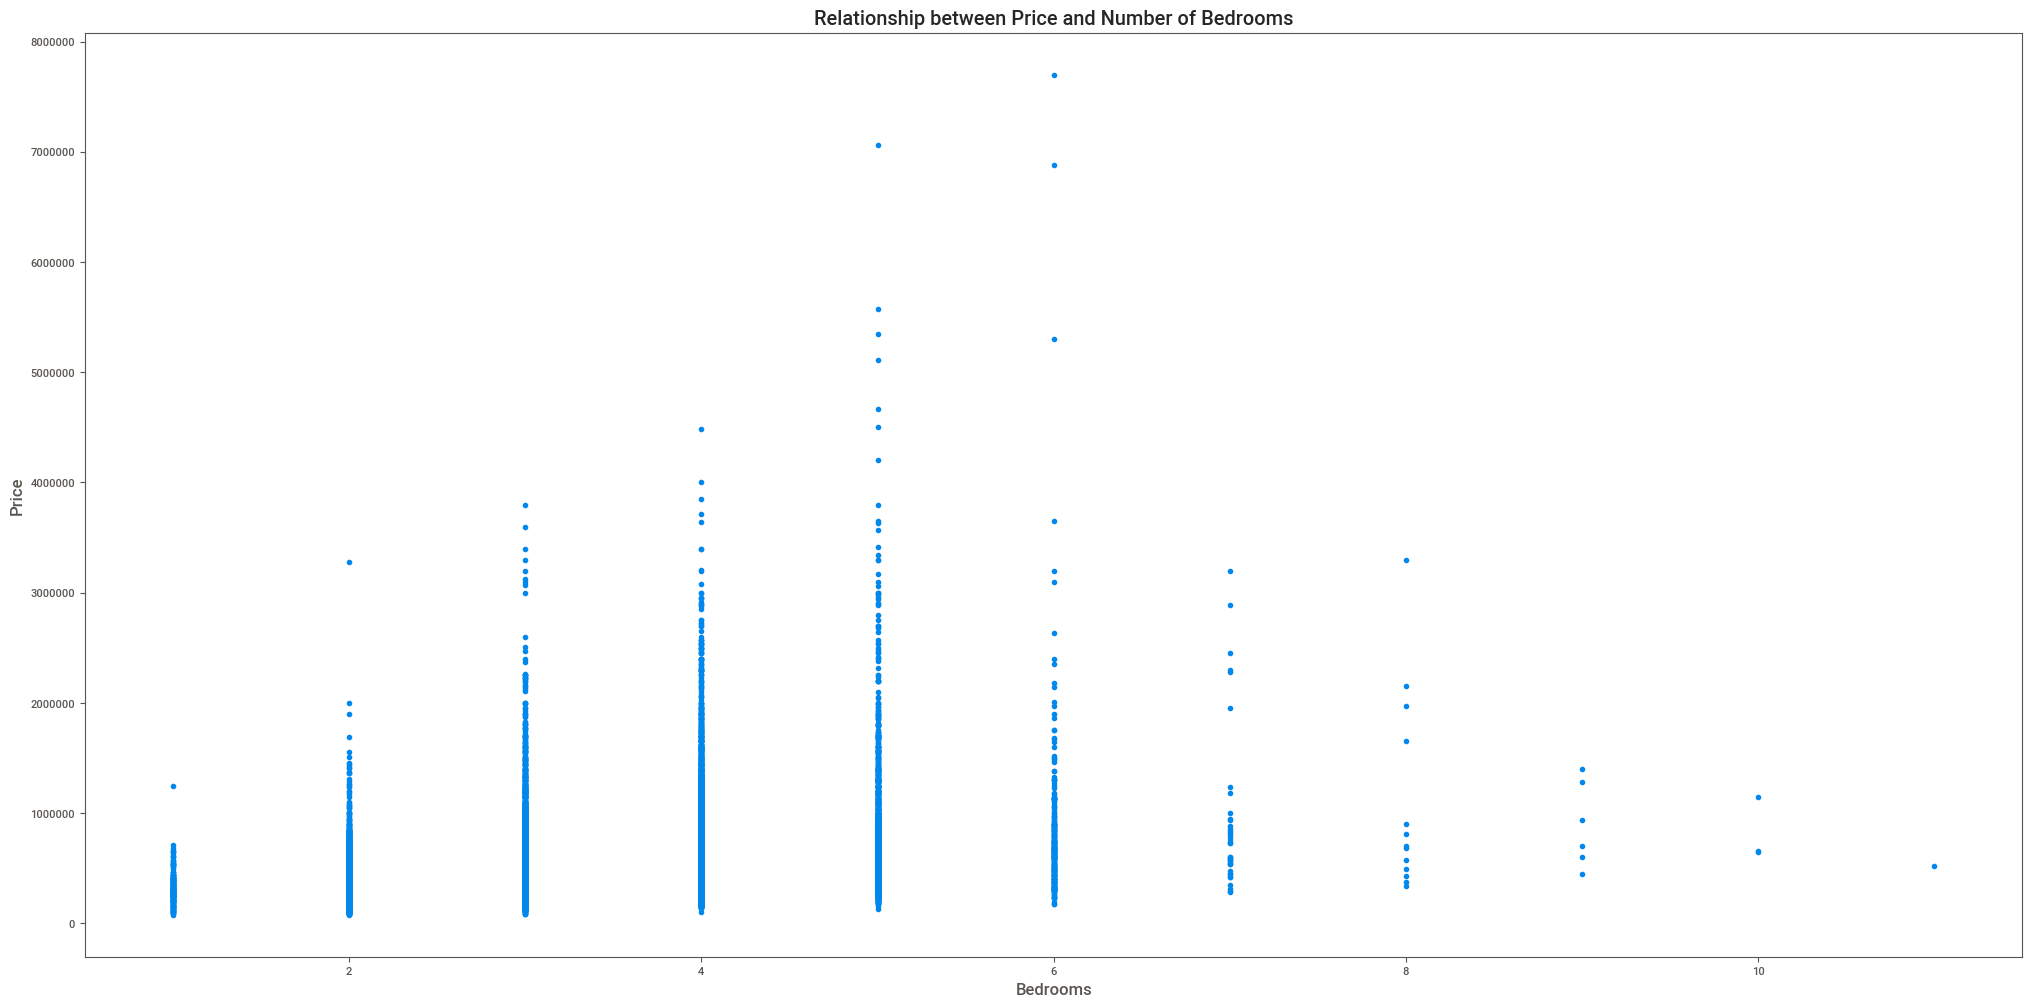

In [38]:
ax = plt.scatter(df4['bedrooms'], df4['price'])

# Labels
plt.xlabel('Bedrooms')
plt.ylabel('Price')
plt.title('Relationship between Price and Number of Bedrooms')

# show
plt.show()

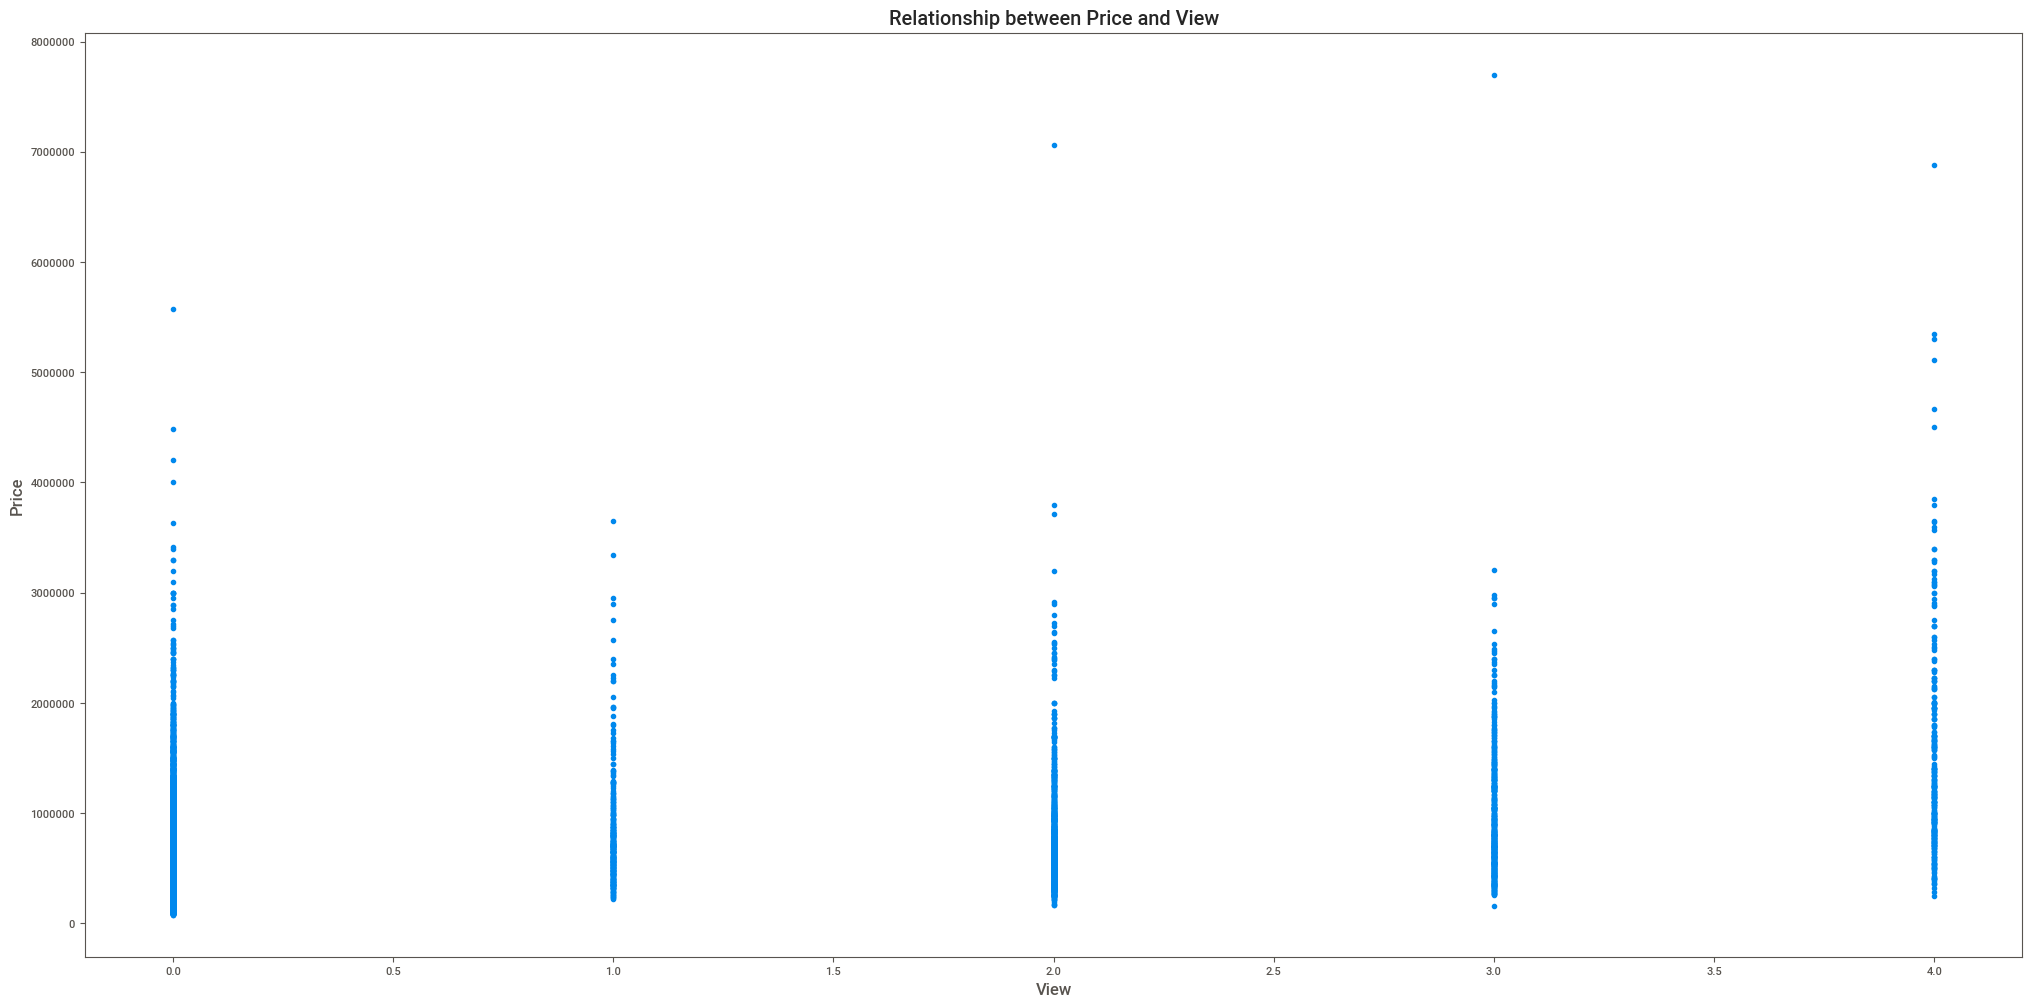

In [39]:
ax = plt.scatter(df4['view'], df4['price'])

# Labels
plt.xlabel('View')
plt.ylabel('Price')
plt.title('Relationship between Price and View')

# show
plt.show()

In [ ]:
ax = plt.scatter(df4['grade'], df4['price'])

# Labels
plt.xlabel('Grade')
plt.ylabel('Price')
plt.title('Relationship between Price and Grade')

# show
plt.show()

# STEP 05 - DATA PREPARATION

In [40]:
df5 = df4.copy()

In [41]:
df5.head()

id       date     price  bedrooms  bathrooms  sqft_living  sqft_lot  floors  waterfront  view  condition  grade  sqft_above  sqft_basement  yr_built  yr_renovated  zipcode      lat     long  sqft_living15  sqft_lot15  year_sales  month_sales  day_of_year_sales
0  7129300520 2014-10-13  221900.0         3       1.00         1180      5650     1.0           0     0          3      7        1180              0      2014          2014    98178  47.5112 -122.257           1340        5650        2014           10                 13
1  6414100192 2014-12-09  538000.0         3       2.25         2570      7242     2.0           0     0          3      7        2170            400      2014          2014    98125  47.7210 -122.319           1690        7639        2014           12                  9
2  5631500400 2015-02-25  180000.0         2       1.00          770     10000     1.0           0     0          3      6         770              0      2015          2015    98028  47.7379 -122.233           2720        8062        2015            2                 25
3  2487200875 2014-12-09  604000.0         4       3.00         1960      5000     1.0           0     0          5      7        1050            910      2014          2014    98136  47.5208 -122.393           1360        5000        2014           12                  9
4  1954400510 2015-02-18  510000.0         3       2.00         1680      8080     1.0           0     0          3      8        1680              0      2015          2015    98074  47.6168 -122.045           1800        7503        2015            2                 18

In [42]:
# drop unnecessary features, replace df
cols_drop = ['id', 'date','zipcode']
df5 = df5.drop( cols_drop, axis=1 )

### Checking for Normal Distribution in a Variable

In [43]:
# Set a significance level
alpha = 0.05

# Apply the Shapiro-Wilk test to each column
test_results = df5.apply(lambda column: shapiro(column))

# Print the result for each column
for column, (stat, p_value) in test_results.items():
    if p_value > alpha:
        print(f"The distribution of column '{column}' appears to be normal (p-value: {p_value:.4f})")
    else:
        print(f"The distribution of column '{column}' does not appear to be normal (p-value: {p_value:.4f})")

The distribution of column 'price' does not appear to be normal (p-value: 0.0000)
The distribution of column 'bedrooms' does not appear to be normal (p-value: 0.0000)
The distribution of column 'bathrooms' does not appear to be normal (p-value: 0.0000)
The distribution of column 'sqft_living' does not appear to be normal (p-value: 0.0000)
The distribution of column 'sqft_lot' does not appear to be normal (p-value: 0.0000)
The distribution of column 'floors' does not appear to be normal (p-value: 0.0000)
The distribution of column 'waterfront' does not appear to be normal (p-value: 0.0000)
The distribution of column 'view' does not appear to be normal (p-value: 0.0000)
The distribution of column 'condition' does not appear to be normal (p-value: 0.0000)
The distribution of column 'grade' does not appear to be normal (p-value: 0.0000)
The distribution of column 'sqft_above' does not appear to be normal (p-value: 0.0000)
The distribution of column 'sqft_basement' does not appear to be nor

## Normalization

Not applicable. The columns of the dataset do not seem to follow a normal distribution.

## Rescaling

In [44]:
df6 = df5.copy()

- Min-Max Scaler (data with fewer outliers)
- Robust Scaler (data with many outliers)

In [45]:
# To determine whether to use Min-Max Scaler or Robust Scaler, it will be necessary to check for outliers in each column.
'''sns.boxplot (df6['sqft_living']) # RobustScaler
sns.boxplot (df6['sqft_lot']) # RobustScaler
sns.boxplot (df6['sqft_above']) # RobustScaler
sns.boxplot (df6['sqft_basement']) # RobustScaler
sns.boxplot (df6['lat']) # MinMaxScaler
sns.boxplot (df6['long']) # MinMaxScaler
sns.boxplot (df6['sqft_living15']) # RobustScaler
sns.boxplot (df6['sqft_lot15']) # RobustScaler'''


"sns.boxplot (df6['sqft_living']) # RobustScaler\nsns.boxplot (df6['sqft_lot']) # RobustScaler\nsns.boxplot (df6['sqft_above']) # RobustScaler\nsns.boxplot (df6['sqft_basement']) # RobustScaler\nsns.boxplot (df6['lat']) # MinMaxScaler\nsns.boxplot (df6['long']) # MinMaxScaler\nsns.boxplot (df6['sqft_living15']) # RobustScaler\nsns.boxplot (df6['sqft_lot15']) # RobustScaler"

In [46]:
rs = RobustScaler()
mms = MinMaxScaler()

# sqft_living - Robust Scaler
df6['sqft_living'] = rs.fit_transform( df6[['sqft_living']].values )

# sqft_lot - Robust Scaler
df6['sqft_lot'] = rs.fit_transform( df6[['sqft_lot']].values )

# sqft_above - Robust Scaler
df6['sqft_above'] = rs.fit_transform( df6[['sqft_above']].values )

# sqft_basement  - Robust Scaler
df6['sqft_basement'] = rs.fit_transform( df6[['sqft_basement']].values )

# lat - Min-Max Scaler
df6['lat'] = mms.fit_transform( df6[['lat']].values )

# long - Min-Max Scaler
df6['long'] = mms.fit_transform( df6[['long']].values )

# sqft_living15 - Robust Scaler
df6['sqft_living15'] = rs.fit_transform( df6[['sqft_living15']].values )

# sqft_lot15 - Robust Scaler
df6['sqft_lot15'] = rs.fit_transform( df6[['sqft_lot15']].values )


## Transformation

### Encoding - NA

### Response Variable Transformation

<Axes: xlabel='price', ylabel='Density'>

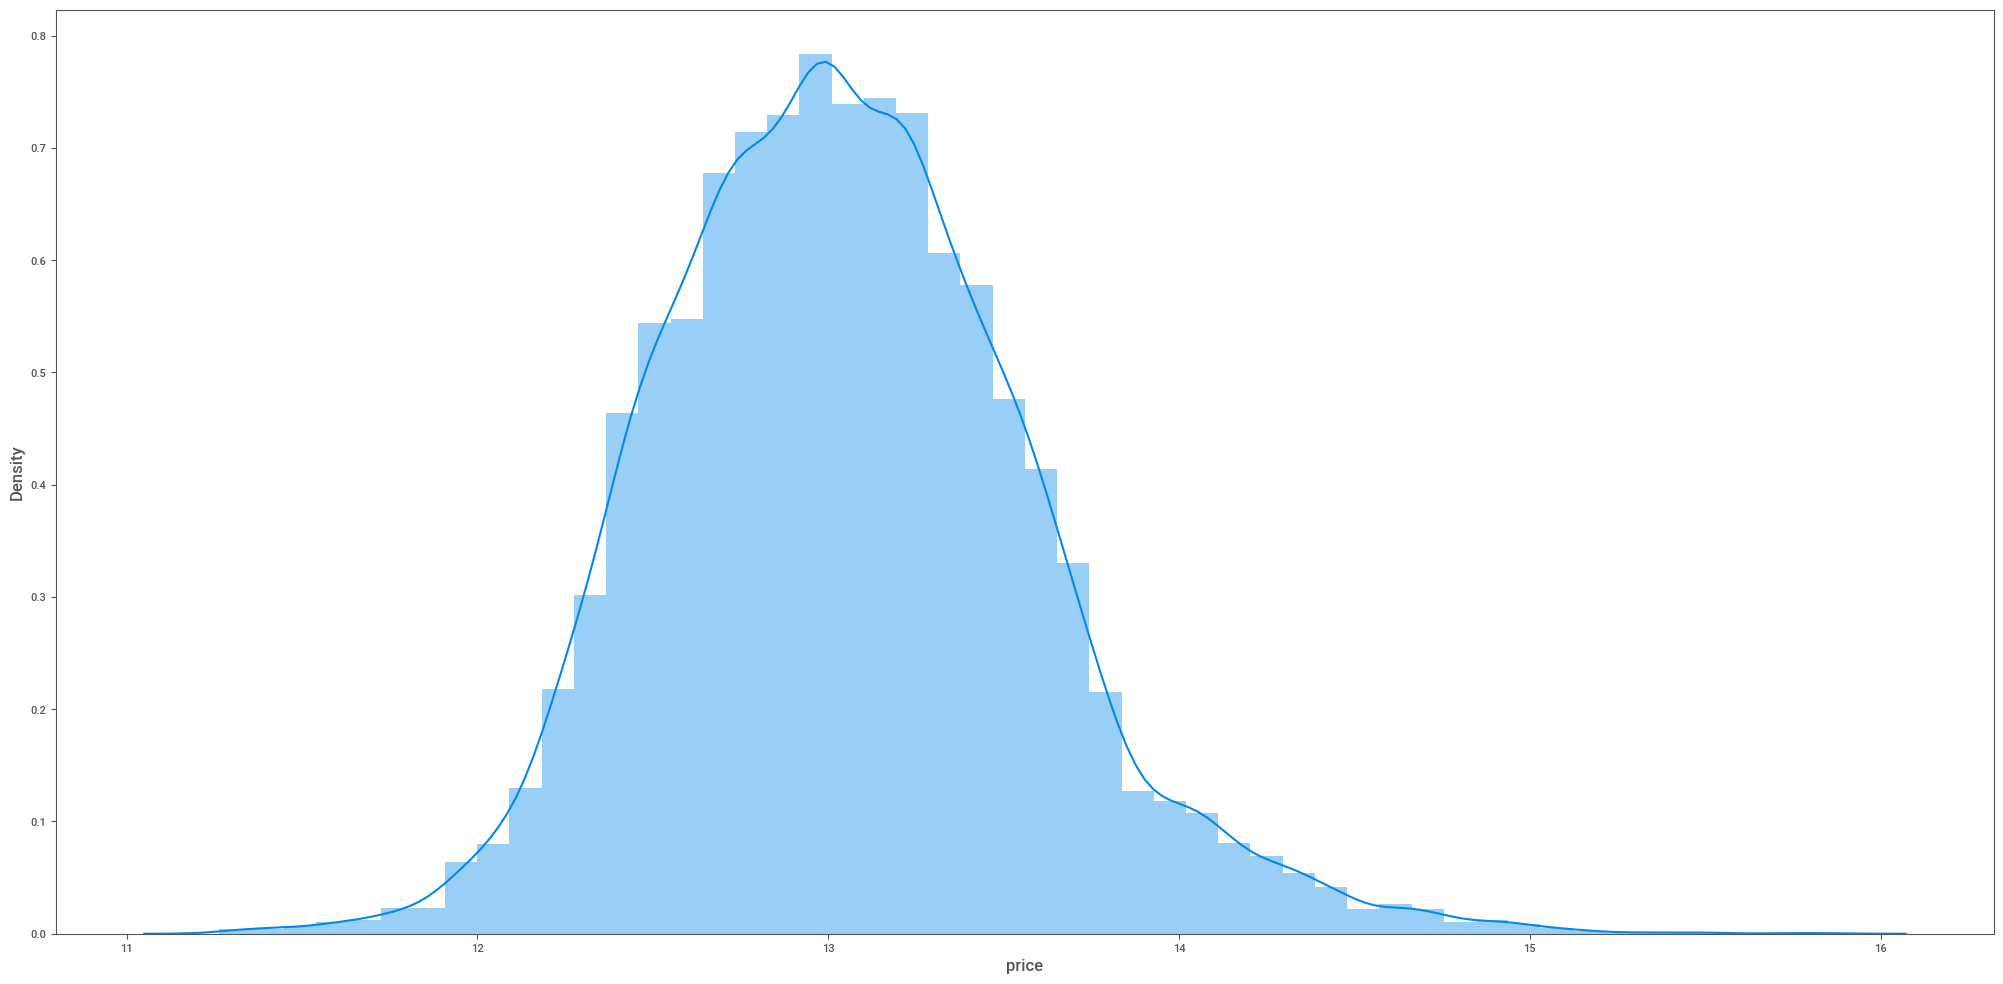

In [47]:
df6 ['price'] = np.log1p(df6['price'])
sns.distplot(df6['price'])

### Nature Transformation

In [48]:
# sales_month
df6['month_sales_sin'] = df6['month_sales'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 ) ) )
df6['month_sales_cos'] = df6['month_sales'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 ) ) )


# day_of_year_sales
df6['day_of_year_sales_sin'] = df6['day_of_year_sales'].apply( lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )
df6['day_of_year_sales_cos'] = df6['day_of_year_sales'].apply( lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )

# STEP 06 - FEATURE SELECTION

In [49]:
cols_drop=['month_sales','day_of_year_sales']
df6 = df6.drop(cols_drop, axis = 1)

In [50]:
df6.head()

price  bedrooms  bathrooms  sqft_living  sqft_lot  floors  waterfront  view  condition  grade  sqft_above  sqft_basement  yr_built  yr_renovated       lat      long  sqft_living15  sqft_lot15  year_sales  month_sales_sin  month_sales_cos  day_of_year_sales_sin  day_of_year_sales_cos
0  12.309987         3       1.00    -0.651786 -0.348773     1.0           0     0          3      7   -0.372549       0.000000      2014          2014  0.571498  0.217608      -0.574713   -0.395344        2014    -8.660254e-01              0.5               0.406737              -0.913545
1  13.195616         3       2.25     0.589286 -0.066779     2.0           0     0          3      7    0.598039       0.714286      2014          2014  0.908959  0.166113      -0.172414    0.003813        2014    -2.449294e-16              1.0               0.951057              -0.309017
2  12.100718         2       1.00    -1.017857  0.421752     1.0           0     0          3      6   -0.774510       0.000000      2015          2015  0.936143  0.237542       1.011494    0.088702        2015     8.660254e-01              0.5              -0.866025               0.500000
3  13.311331         4       3.00     0.044643 -0.463909     1.0           0     0          5      7   -0.500000       1.625000      2014          2014  0.586939  0.104651      -0.551724   -0.525788        2014    -2.449294e-16              1.0               0.951057              -0.309017
4  13.142168         3       2.00    -0.205357  0.081658     1.0           0     0          3      8    0.117647       0.000000      2015          2015  0.741354  0.393688      -0.045977   -0.023480        2015     8.660254e-01              0.5              -0.587785              -0.809017

In [51]:
df7 = df6.copy()

## Split data frame into training and test dataset

In [52]:
# validation dataset - its wrong ! the validation, test and training dataset have to be equal in the proportions - ITS WRONG
#df_head = df7.head(50)
#df_tail = df7.tail(50)

#df_val = pd.concat([df_head, df_tail])
#df_val.reset_index(inplace=True)
#df_validation = df_val.price

#df_val = df_val.drop(['index', 'price'], axis = 1)

## Boruta as Feature Selector

In [53]:
# training dataset
X = df7.drop(['price'], axis = 1)
y = df7['price']

# Divide dataset train and test
X_train_n, X_test_n, y_train_n, y_test_n = train_test_split(X, y, test_size=0.3, random_state=42)

# Define RandomForestRegressor
rf = RandomForestRegressor(n_jobs=-1)

# Boruta
boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42).fit(X_train_n.values, y_train_n.values)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	22
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	22
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	22
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	22
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	22
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	22
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	22
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	10
Tentative: 	0
Rejected: 	12


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	10
Tentative: 	0
Rejected: 	12


### Best Features from Boruta

In [55]:
#Best features
features_selected = boruta.support_.tolist()

features_selected_boruta = X_train_n.iloc[:,features_selected].columns.to_list()

features_selected_boruta

['sqft_living',
 'sqft_lot',
 'waterfront',
 'view',
 'grade',
 'sqft_above',
 'lat',
 'long',
 'sqft_living15',
 'sqft_lot15']

In [56]:
# Features not selected
features_not_selected_borut = list( np.setdiff1d( X_train_n.columns,features_selected_boruta ) )

features_not_selected_borut

['bathrooms',
 'bedrooms',
 'condition',
 'day_of_year_sales_cos',
 'day_of_year_sales_sin',
 'floors',
 'month_sales_cos',
 'month_sales_sin',
 'sqft_basement',
 'year_sales',
 'yr_built',
 'yr_renovated']

## Manual Feature Selection

In [57]:
df8 = df7.copy()

In [58]:
cols_selected = [
    'sqft_living',
    'sqft_lot',
    'waterfront',
    'view',
    'grade',
    'sqft_above',
    'lat',
    'long',
    'sqft_living15',
    'sqft_lot15',
    'bathrooms',
    'bedrooms',
    'price']


In [59]:
df_selected = df8[cols_selected]

In [60]:
df_selected.head()

sqft_living  sqft_lot  waterfront  view  grade  sqft_above       lat      long  sqft_living15  sqft_lot15  bathrooms  bedrooms      price
0    -0.651786 -0.348773           0     0      7   -0.372549  0.571498  0.217608      -0.574713   -0.395344       1.00         3  12.309987
1     0.589286 -0.066779           0     0      7    0.598039  0.908959  0.166113      -0.172414    0.003813       2.25         3  13.195616
2    -1.017857  0.421752           0     0      6   -0.774510  0.936143  0.237542       1.011494    0.088702       1.00         2  12.100718
3     0.044643 -0.463909           0     0      7   -0.500000  0.586939  0.104651      -0.551724   -0.525788       3.00         4  13.311331
4    -0.205357  0.081658           0     0      8    0.117647  0.741354  0.393688      -0.045977   -0.023480       2.00         3  13.142168

In [61]:
x_train = df_selected.drop(['price'], axis = 1)
y_train = df_selected['price']


x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.3, random_state=42)

# STEP 07 - MACHINE LEARNING MODELING

## Linear Regression Model

In [62]:
# model
lr = LinearRegression()

# fit
lr.fit(x_train, y_train)

# prediction
ypred_lr = lr.predict(x_test)

# performance
lr_result = ml_error('Linear Regression', np.expm1(y_test), np.expm1(ypred_lr))  # exp1 é usado para colocar os dados na mesma escala
lr_result

Model Name            MAE      MAPE          RMSE
0  Linear Regression  118658.702999  0.216369  197492.39779

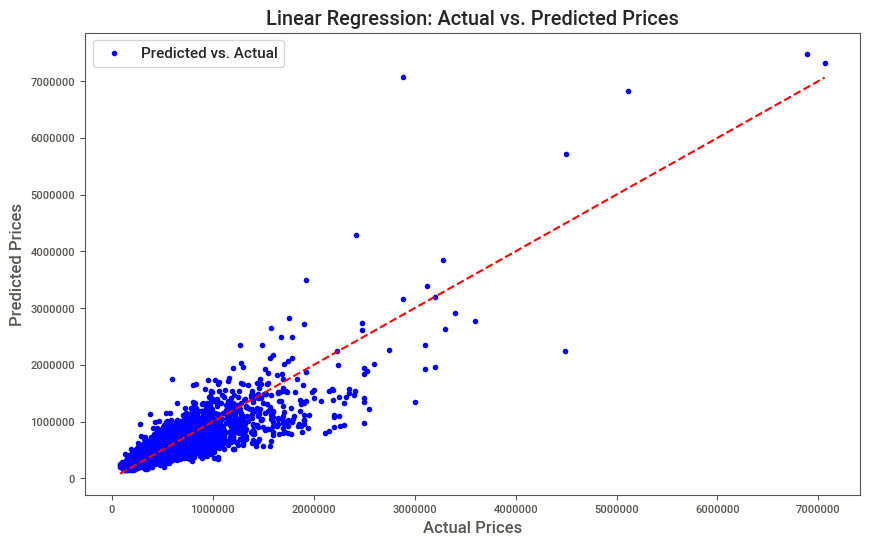

In [64]:
# Plot
plt.figure(figsize=(10,6))
plt.scatter(np.expm1(y_test), np.expm1(ypred_lr), color='blue', label='Predicted vs. Actual')
plt.plot([min(np.expm1(y_test)), max(np.expm1(y_test))], [min(np.expm1(y_test)), max(np.expm1(y_test))], color='red', linestyle='--')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Linear Regression: Actual vs. Predicted Prices')
plt.legend(loc='upper left')
plt.show()

## Linear Regression Regularized Model - Lasso

In [63]:
# model
lrl = Lasso(alpha = 0.01) # o parâmetro alpha irá restringir os valores dentro de uma faixa - para que tenham a mesma relevância - e sejam comparáveis 

# fit
lrl.fit(x_train, y_train)

# prediction
ypred_lrl = lrl.predict(x_test)

# performance
lrl_result = ml_error('Linear Regression - Lasso', np.expm1(y_test), np.expm1(ypred_lrl))  # exp1 é usado para colocar os dados na mesma escala
lrl_result

Model Name            MAE      MAPE           RMSE
0  Linear Regression - Lasso  121249.819427  0.220917  203128.845411

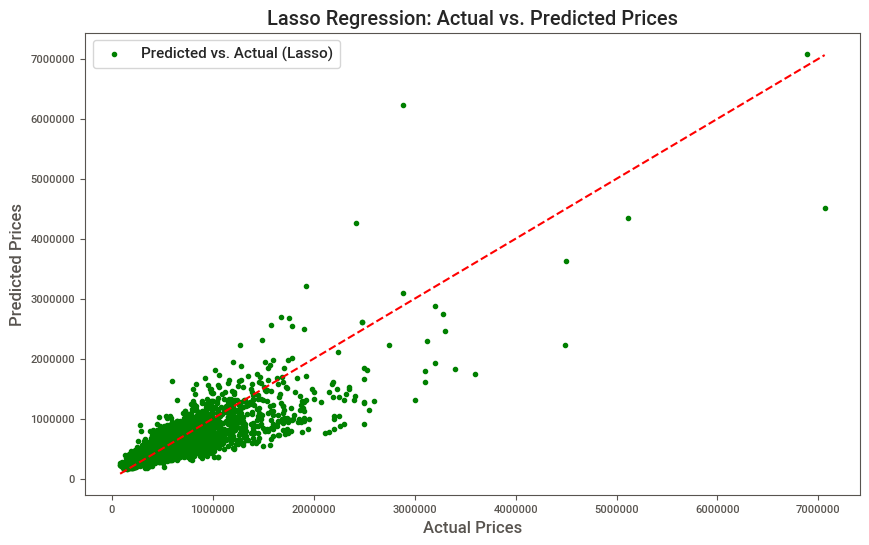

In [65]:
# Plot
plt.figure(figsize=(10,6))
plt.scatter(np.expm1(y_test), np.expm1(ypred_lrl), color='green', label='Predicted vs. Actual (Lasso)')
plt.plot([min(np.expm1(y_test)), max(np.expm1(y_test))], [min(np.expm1(y_test)), max(np.expm1(y_test))], color='red', linestyle='--')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Lasso Regression: Actual vs. Predicted Prices')
plt.legend(loc='upper left')
plt.show()

### Linear Regression Model - Cross Validation

###  Lasso - Cross Validation

## Random Forest Regressor

In [66]:
# COM AS FEATURES SELECIONADAS - SEPARANDO EM TREINO E TESTE
# model
rf = RandomForestRegressor(n_estimators=100, n_jobs= -1, random_state=42) # o parâmetro alpha irá restringir os valores dentro de uma faixa - para que tenham a mesma relevância - e sejam comparáveis 

# fit
rf.fit(x_train, y_train)

# prediction
ypred_rf = rf.predict(x_test)

# performance
rf_result = ml_error('Random Forest Regressor', np.expm1(y_test), np.expm1(ypred_rf))  # exp1 é usado para colocar os dados na mesma escala
rf_result



Model Name           MAE      MAPE           RMSE
0  Random Forest Regressor  70184.127395  0.131119  131489.871743

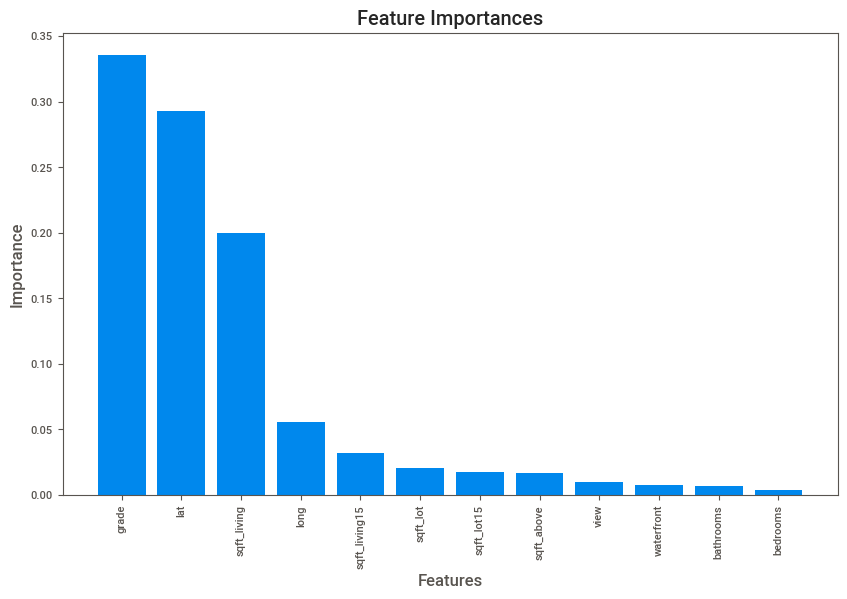

In [77]:
# model
rf = RandomForestRegressor(n_estimators=100, n_jobs= -1, random_state=42) # o parâmetro alpha irá restringir os valores dentro de uma faixa - para que tenham a mesma relevância - e sejam comparáveis 

# fit
rf.fit(x_train, y_train)

# Obtendo a importância das features
importances = rf.feature_importances_

# Ordenando as importâncias em ordem decrescente
indices = np.argsort(importances)[::-1]

# Plotando as importâncias
plt.figure(figsize=(10,6))
plt.title("Feature Importances")
plt.bar(range(x_train.shape[1]), importances[indices], align="center")
plt.xticks(range(x_train.shape[1]), x_train.columns[indices], rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()

### Random Forest Regressor - Cross Validation

## XGBoost Regressor

In [74]:
# COM AS FEATURES SELECIONADAS - SEPARANDO EM TREINO E TESTE
# model
model_xgb = xgb.XGBRegressor(objective='reg:squarederror',n_estimators=100, eta=0.01, max_depth=10, subsample=0.7, colsample_bytee=0.9)

# fit
model_xgb.fit(x_train, y_train)

# prediction
ypred_xgb = model_xgb.predict(x_test)

# performance
xgb_result = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(ypred_xgb))  # exp1 é usado para colocar os dados na mesma escala
xgb_result

Model Name            MAE      MAPE           RMSE
0  XGBoost Regressor  114004.707128  0.201974  238091.028774

### XGBoost Regressor - Cross Validation

## Compare Model's Performance

In [79]:
#result_models = pd.concat([lr_result, lrl_result, rf_result, xgb_result])
#result_models.sort_values('MAE')

Model Name            MAE      MAPE           RMSE
0    Random Forest Regressor   70184.127395  0.131119  131489.871743
0          XGBoost Regressor  114004.707128  0.201974  238091.028774
0          Linear Regression  118658.702999  0.216369  197492.397790
0  Linear Regression - Lasso  121249.819427  0.220917  203128.845411

In [82]:
result_models = pd.concat([lr_result, lrl_result, rf_result, xgb_result])

# Ordenando os resultados por MAE
result_models_sorted = result_models.sort_values('MAE')

# Formatação das colunas MAE e MAPE
result_models_sorted['MAE'] = result_models_sorted['MAE'].map('${:,.2f}'.format)
result_models_sorted['MAPE'] = (result_models_sorted['MAPE']*100).map('{:.2f}%'.format)
result_models_sorted['RMSE'] = result_models_sorted['RMSE'].map('${:,.2f}'.format)

# Exibindo os resultados
print(result_models_sorted)

                  Model Name          MAE    MAPE         RMSE
0    Random Forest Regressor   $70,184.13  13.11%  $131,489.87
0          XGBoost Regressor  $114,004.71  20.20%  $238,091.03
0          Linear Regression  $118,658.70  21.64%  $197,492.40
0  Linear Regression - Lasso  $121,249.82  22.09%  $203,128.85


Para cada predição que o modelo fizer teremos um erro de $ 70,184.13 que representa 13.11% . 



### Single Performance

### Real Performance - Cross Validation

# STEP 08 - HYPER PARAMETER FINE TUNING

## Random Search

In [ ]:
'''# Defina os parâmetros que você deseja otimizar
parametros_grid = {
    'n_estimators': [10, 50, 100],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Crie um modelo de Random Forest Regressor
modelo_rf = RandomForestRegressor()

# Crie um objeto GridSearchCV com cross-validation
grid_search = GridSearchCV(estimator=modelo_rf, param_grid=parametros_grid, scoring='neg_mean_squared_error', cv=KFold(n_splits=5, shuffle=True, random_state=42))

# Ajuste o modelo ao conjunto de dados usando GridSearchCV
grid_search.fit(x_train, y_train)

# Extrai os melhores resultados do GridSearchCV
melhores_resultados = grid_search.best_estimator_

# Avalia o modelo usando as métricas personalizadas no conjunto de teste
y_pred = grid_search.predict(x_test)  # Substitua 'x_test' pelos seus dados de teste
resultado_metricas = ml_error('Random Forest', np.expm1(y_test), np.expm1(y_pred))  # exp1 é usado para colocar os dados na mesma escala

# Imprime os melhores parâmetros e o desempenho associado
print("Melhores Parâmetros:", grid_search.best_params_)
print("Melhor Pontuação (MSE):", -grid_search.best_score_)

# Imprime as métricas personalizadas
print(resultado_metricas)'''

In [ ]:
'''Melhores Parâmetros: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Melhor Pontuação (MSE): 0.032800634976917445
      Model Name           MAE      MAPE           RMSE
0  Random Forest  70504.367474  0.131037  132897.990281'''

In [ ]:
'''# Defina os parâmetros que você deseja otimizar
parametros_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Crie um modelo de Random Forest Regressor
modelo_rf = RandomForestRegressor()

# Crie um objeto GridSearchCV com cross-validation
grid_search = GridSearchCV(estimator=modelo_rf, param_grid=parametros_grid, scoring='neg_mean_squared_error', cv=KFold(n_splits=5, shuffle=True, random_state=42))

# Ajuste o modelo ao conjunto de dados usando GridSearchCV
grid_search.fit(x_train, y_train)

# Extrai os melhores resultados do GridSearchCV
melhores_resultados = grid_search.best_estimator_

# Avalia o modelo usando as métricas personalizadas no conjunto de teste
y_pred = grid_search.predict(x_test)  # Substitua 'x_test' pelos seus dados de teste
resultado_metricas = ml_error('Random Forest', np.expm1(y_test), np.expm1(y_pred))  # exp1 é usado para colocar os dados na mesma escala

# Imprime os melhores parâmetros e o desempenho associado
print("Melhores Parâmetros:", grid_search.best_params_)
print("Melhor Pontuação (MSE):", -grid_search.best_score_)

# Imprime as métricas personalizadas
print(resultado_metricas)'''

In [ ]:
'''Melhores Parâmetros: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 150}
Melhor Pontuação (MSE): 0.0327123560889278
      Model Name           MAE      MAPE          RMSE
0  Random Forest  70768.251683  0.130772  134147.73298'''

## Final Model

# STEP 09 - TRADUCAO E INTERPRETACAO DO ERRO

## Business Performance

## Total Performance

## Machine Learning Performance